## WEEK 1 
Plotting the light curve of the CZTI is the first task that was alloted 


Filename: AS1C09_006T01_9000006294_47011cztM0_level2_quad_clean.evt
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     131   ()      
  1  Q0            1 BinTableHDU    116   718481R x 12C   [D, D, I, I, B, B, B, B, I, B, I, E]   
  2  Q1            1 BinTableHDU    116   349696R x 12C   [D, D, I, I, B, B, B, B, I, B, I, E]   
  3  Q2            1 BinTableHDU    116   708156R x 12C   [D, D, I, I, B, B, B, B, I, B, I, E]   
  4  Q3            1 BinTableHDU    116   625144R x 12C   [D, D, I, I, B, B, B, B, I, B, I, E]   
  5  VETOSPECTRUM    1 BinTableHDU    117   25002R x 4C   [D, D, 256I, B]   
  6  SSM Data      1 BinTableHDU    133   252R x 7C   [D, D, 256I, 512I, 512I, 512I, B]   
  7  TEMP          1 BinTableHDU    124   252R x 4C   [D, D, 16E, B]   
  8  Q0_GTI        1 BinTableHDU     62   1015R x 2C   [1D, 1D]   
  9  Q1_GTI        1 BinTableHDU     62   904R x 2C   [1D, 1D]   
 10  Q2_GTI        1 BinTableHDU     62   876R x 2C   

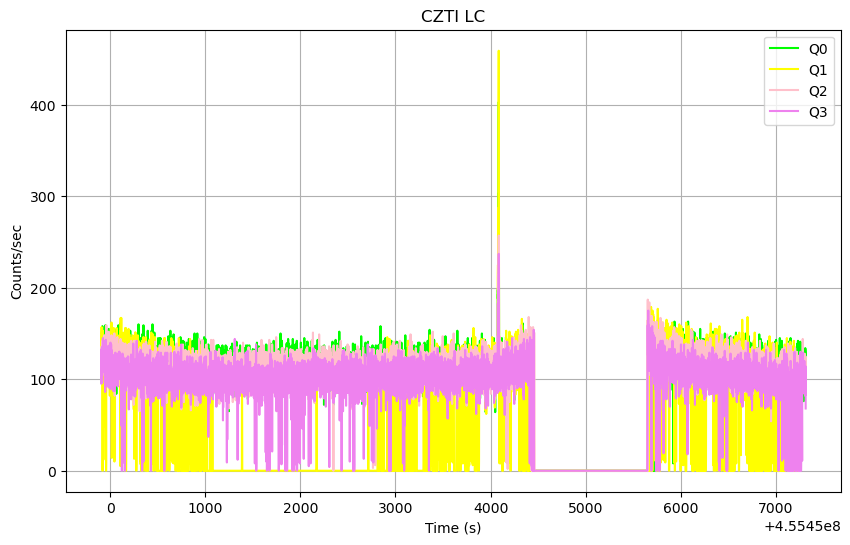

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

hdul = fits.open("AS1C09_006T01_9000006294_47011cztM0_level2_quad_clean.evt")

hdul.info()
q0=hdul["Q0"]
q1=hdul["Q1"]
q2=hdul["Q2"]
q3=hdul["Q3"]
veto = hdul["VETOSPECTRUM"]
times_q0 = q0.data["TIME"]
times_q1 = q1.data["TIME"]
times_q2 = q2.data["TIME"]
times_q3 = q3.data["TIME"]


def counts_per_sec(times, bin_width):
  time_min = times.min()
  time_max = times.max()
  bins = np.arange(time_min, time_max + bin_width, bin_width)
  counts, _ = np.histogram(times, bins=bins)
  bin_centers = bins[:-1] + bin_width / 2
  return bin_centers, counts / bin_width

x0, cps_q0 =  counts_per_sec(times_q0,bin_width=1)
x1, cps_q1 =  counts_per_sec(times_q1,bin_width=1)
x2, cps_q2 =  counts_per_sec(times_q2,bin_width=1)
x3, cps_q3 =  counts_per_sec(times_q3,bin_width=1)

plt.figure(figsize=(10, 6))
plt.plot(x0, cps_q0, label='Q0',color='lime')
plt.plot(x1, cps_q1, label='Q1', color='yellow')
plt.plot(x2, cps_q2, label='Q2',color='pink')
plt.plot(x3, cps_q3, label='Q3',color='violet')
plt.xlabel('Time (s)')
plt.ylabel('Counts/sec')
plt.title('CZTI LC')

plt.legend()
plt.grid(True)
plt.show()


In [2]:
q1.columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 's'
    name = 'CZTSECCNT'; format = 'D'; unit = 's'
    name = 'CZTNTICK'; format = 'I'; unit = 'micro-sec'; bscale = 1; bzero = 32768
    name = 'PHA'; format = 'I'; unit = 'counts'; bscale = 1; bzero = 32768
    name = 'DetID'; format = 'B'
    name = 'pixID'; format = 'B'
    name = 'DETX'; format = 'B'
    name = 'DETY'; format = 'B'
    name = 'veto'; format = 'I'; unit = 'counts'; bscale = 1; bzero = 32768
    name = 'alpha'; format = 'B'; unit = 'counts'
    name = 'PI'; format = 'I'; bscale = 1; bzero = 32768
    name = 'ENERGY'; format = 'E'
)

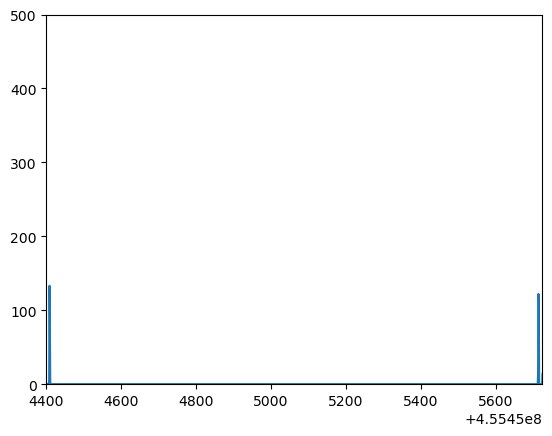

In [9]:
eps = 4.5545e8
plt.plot(x0, cps_q0, label='Q0')
plt.xlim(4400+eps,5725+eps)
plt.ylim(0,500)
plt.show()

# WEEK-2


   ### Plotting the different Energy resolved plots of the CZTI and VETO and filtering it out using few known filters

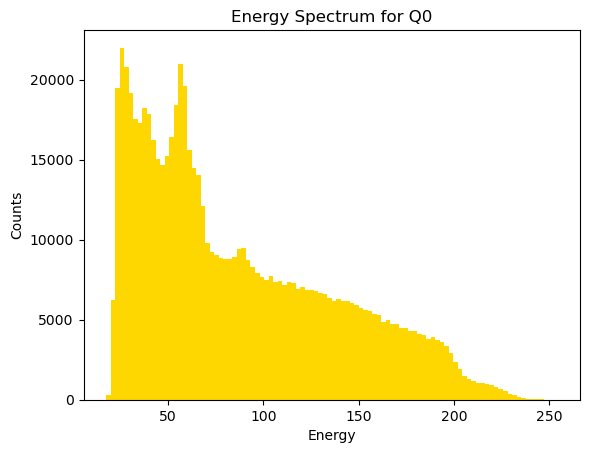

In [4]:

energy_q0 = q0.data["ENERGY"]
plt.hist(energy_q0, bins=100, color='gold')
plt.xlabel("Energy")
plt.ylabel("Counts")
plt.title("Energy Spectrum for Q0")
plt.show()

In [5]:
print(len(energy_q0),len(times_q0))

718481 718481


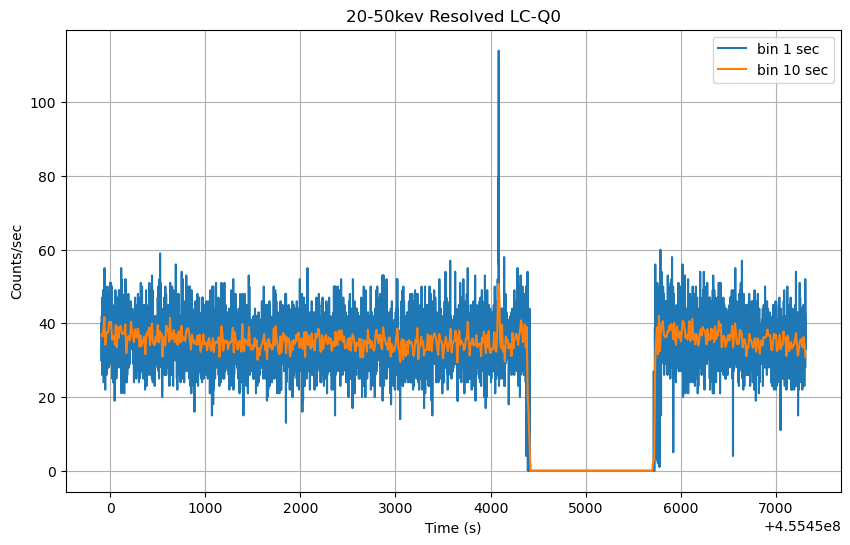

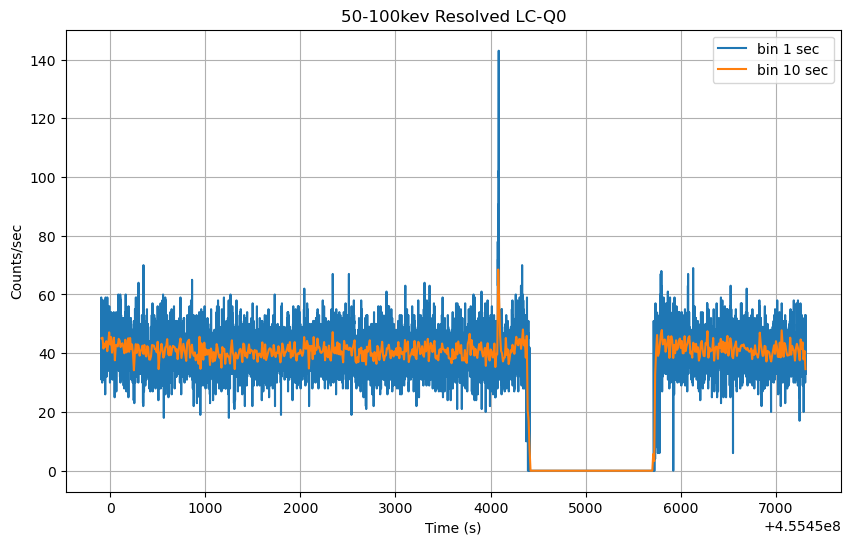

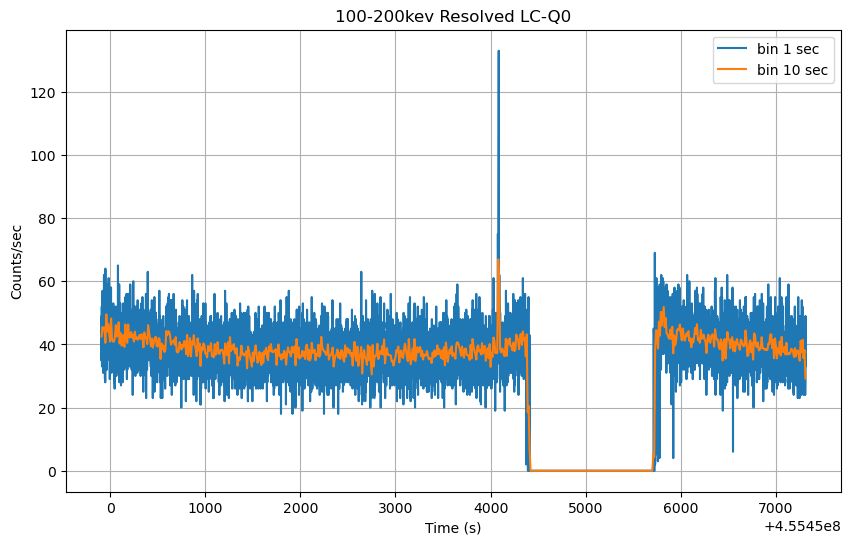

In [6]:
energy_bands = [(20,50),(50,100),(100,200)]
bin_widths=[1,10]
for (emin,emax) in energy_bands:
    mask = (energy_q0 > emin) & (energy_q0 < emax)
    times_filtered = times_q0[mask] 
    x0, cps_q0 = counts_per_sec(times_filtered, bin_width=1)
    x0t, cps_q0_t = counts_per_sec(times_filtered, bin_width=10)
    plt.figure(figsize=(10, 6))
    plt.plot(x0, cps_q0,label='bin 1 sec')
    plt.plot(x0t, cps_q0_t,label='bin 10 sec')
    plt.xlabel('Time (s)')
    plt.ylabel('Counts/sec')
    plt.title(f"{emin}-{emax}kev Resolved LC-Q0")
    plt.grid(True)
    plt.legend()
    plt.show()



# Savgol Filter
Its been noticed that if we use just the Savgol filter alone the noise reduction isnt that good as we take a polynomial which may not be able to adapt sharp curvatures , as our potential GRB spike is not a polynomial fit for sure it averages out and brings the peak down 

<Figure size 1000x600 with 0 Axes>

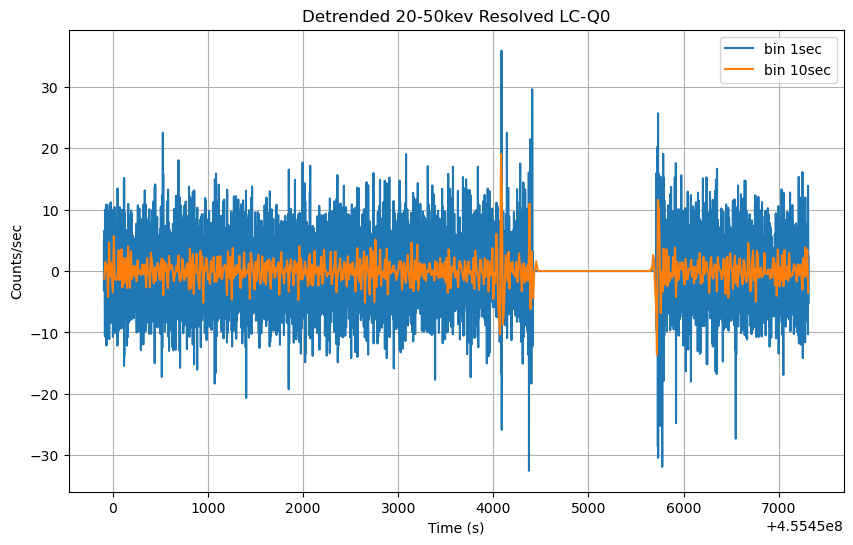

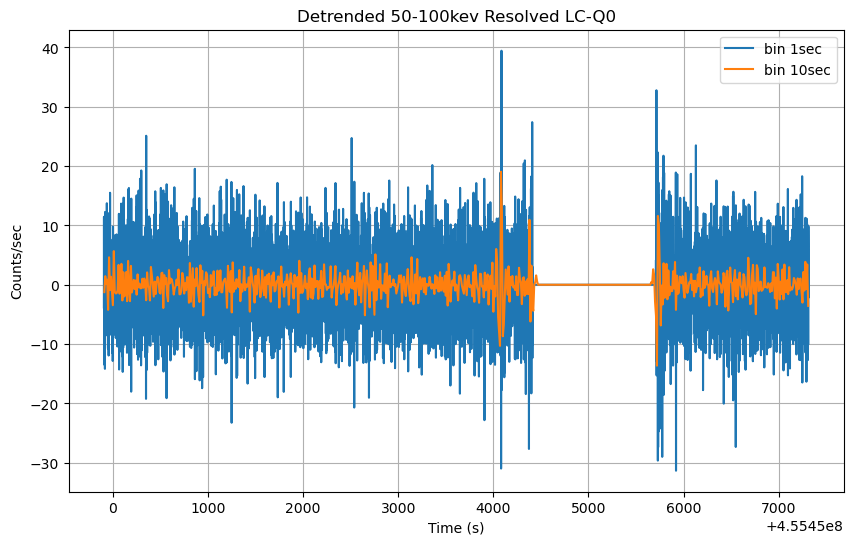

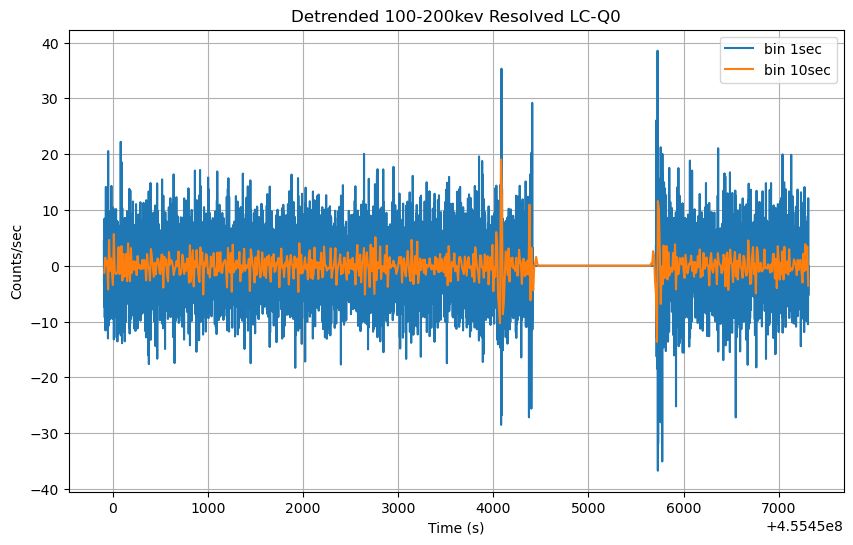

In [7]:
energy_bands = [(20, 50), (50, 100), (100, 200)]
window_length = 11
polyorder = 2
plt.figure(figsize=(10, 6))

for (emin, emax) in energy_bands:
    mask = (energy_q0 > emin) & (energy_q0 < emax)
    times_filtered = times_q0[mask] 
    x0, cps_q0 = counts_per_sec(times_filtered, bin_width=1)
    plt.figure(figsize=(10, 6))
    cps_q0_smooth = savgol_filter(cps_q0, window_length=window_length, polyorder=polyorder)
    cps_q0t_smooth = savgol_filter(cps_q0_t, window_length=window_length, polyorder=polyorder)
    detresav = cps_q0 - cps_q0_smooth
    detresavt = cps_q0_t - cps_q0t_smooth
    plt.plot(x0,detresav,label='bin 1sec')
    plt.plot(x0t,detresavt,label='bin 10sec')
    plt.xlabel('Time (s)')
    plt.ylabel('Counts/sec')
    plt.title(f"Detrended {emin}-{emax}kev Resolved LC-Q0")
    plt.grid(True)
    plt.legend()
    plt.show()



# Median Filter


<Figure size 1000x600 with 0 Axes>

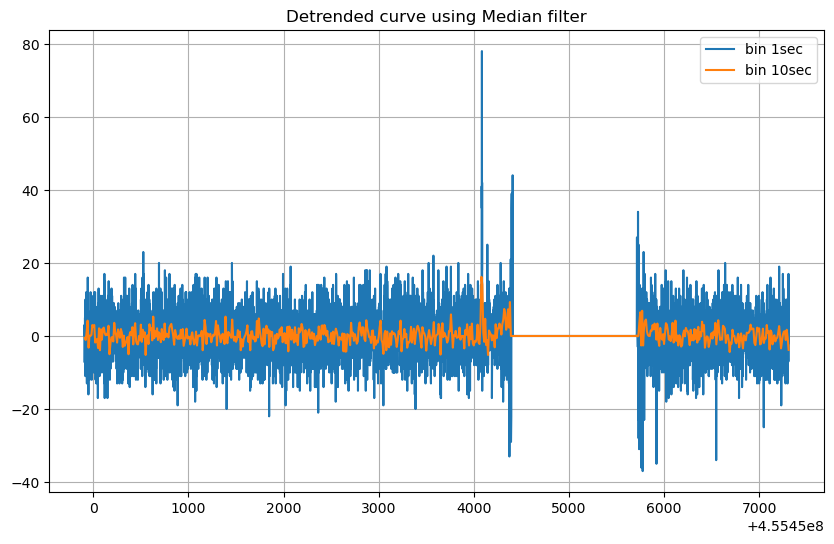

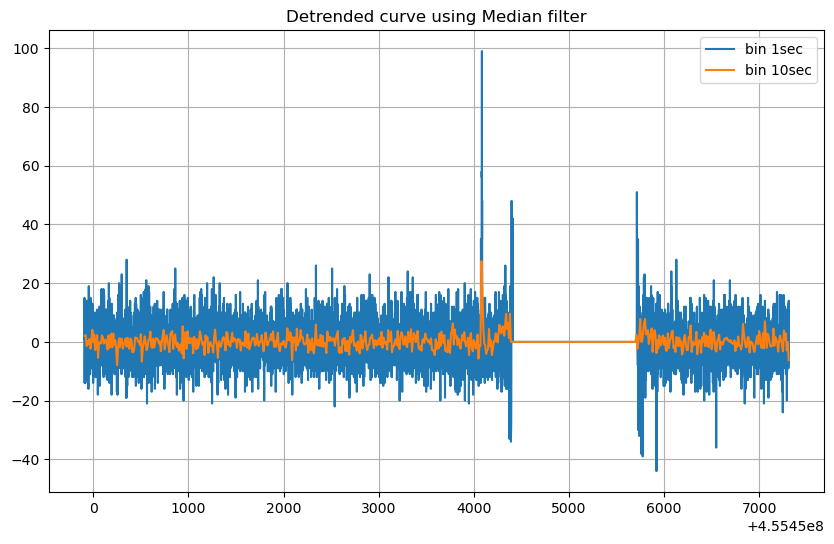

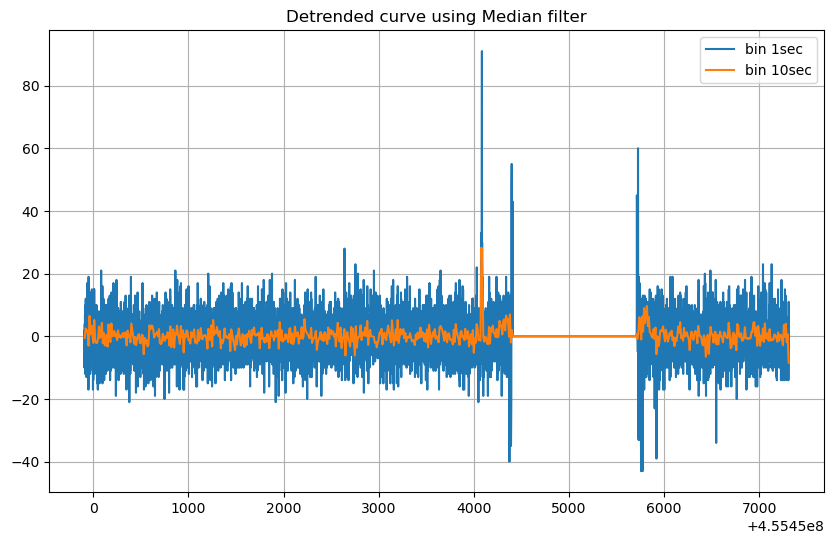

In [8]:
from scipy.ndimage import median_filter
energy_bands = [(20, 50), (50, 100), (100, 200)]

plt.figure(figsize=(10, 6))

for (emin, emax) in energy_bands:
    mask = (energy_q0 > emin) & (energy_q0 < emax)
    times_filtered = times_q0[mask] 
    x0, cps_q0 = counts_per_sec(times_filtered, bin_width=1)
    x0t, cps_q0_t = counts_per_sec(times_filtered, bin_width=10)
    plt.figure(figsize=(10, 6))
    median1 = median_filter(cps_q0,size=51)
    median2 = median_filter(cps_q0_t,size=51)
    detrended = cps_q0 - median1
    detrended0 = cps_q0_t - median2
    plt.plot(x0, detrended, label='bin 1sec')
    plt.plot(x0t, detrended0, label='bin 10sec')
    plt.title('Detrended curve using Median filter')
    plt.grid(True)
    plt.legend()
    plt.show()

## Matched Filter
So as gravitational waves are even more noisy and using a matched filter denoise pretty much efficiently so trying to use this in a sharp GRB signal will be a good try

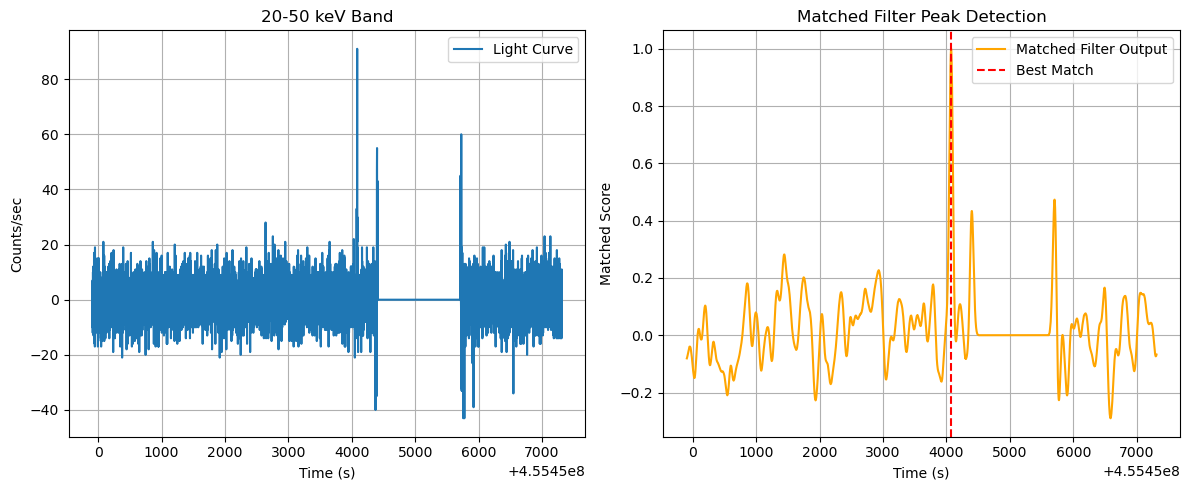

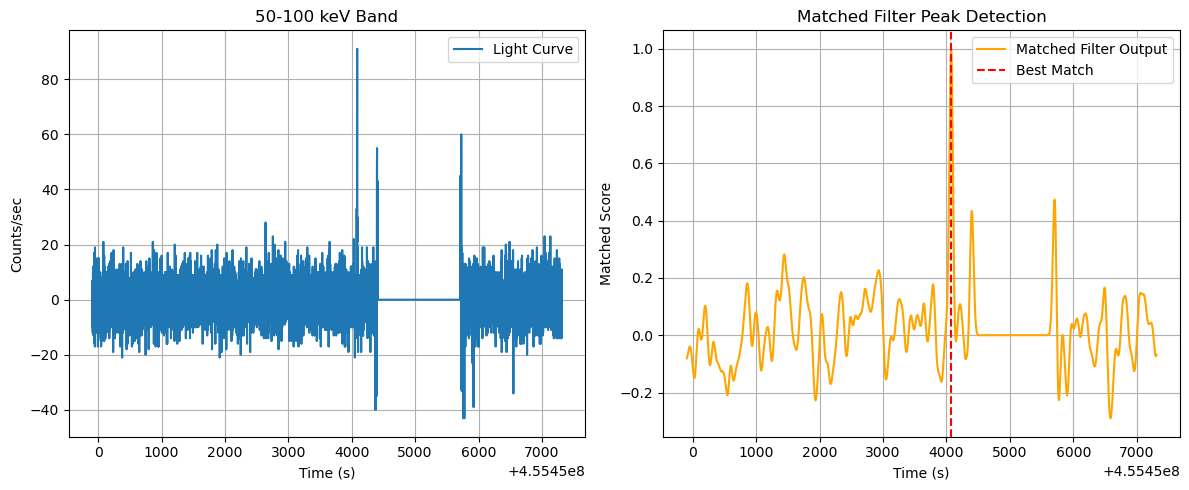

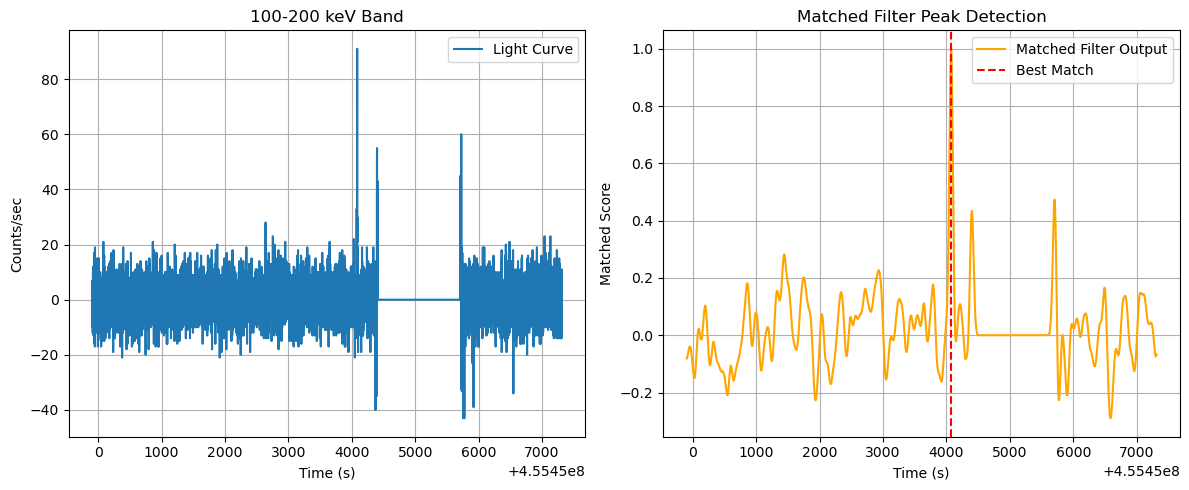

In [9]:
from scipy.signal import correlate
template_center = 1
template_width = 3
template_time = np.linspace(-10, 10, 200)
template = np.exp(-0.5 * ((template_time - template_center)/template_width)**2)

for (emin, emax) in energy_bands:
    mask = (energy_q0 > emin) & (energy_q0 < emax)
    times_filtered = times_q0[mask]
    x0, cps_q0 = counts_per_sec(times_filtered, bin_width=1)
    
    matched = correlate(detrended, template, mode='same')
    matched /= np.max(matched)  
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x0, detrended, label='Light Curve')
    plt.xlabel("Time (s)")
    plt.ylabel("Counts/sec")
    plt.title(f"{emin}-{emax} keV Band")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(x0, matched, label='Matched Filter Output', color='orange')
    plt.axvline(x0[np.argmax(matched)], color='red', linestyle='--', label='Best Match')
    plt.xlabel("Time (s)")
    plt.ylabel("Matched Score")
    plt.title("Matched Filter Peak Detection")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

## Wavelet Denoising 
Maybe a solid approach of dividing it into wavelets and denoising.

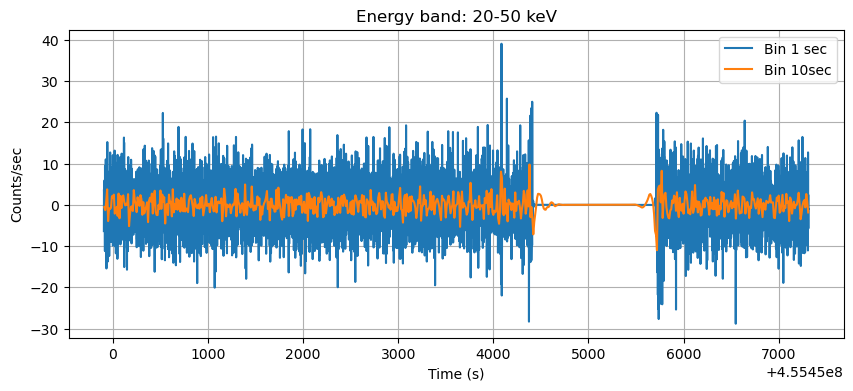

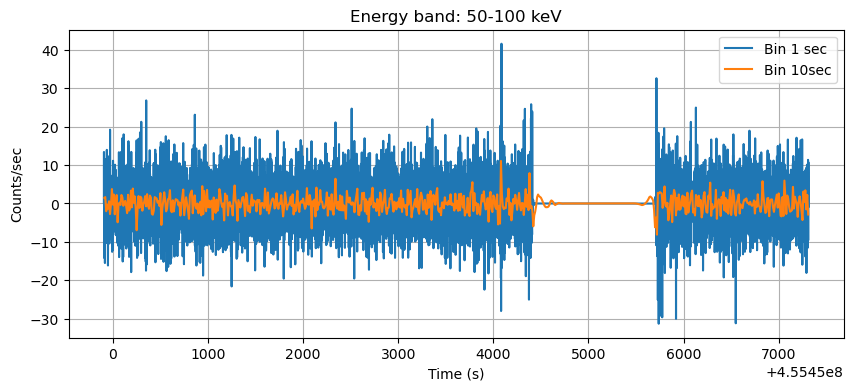

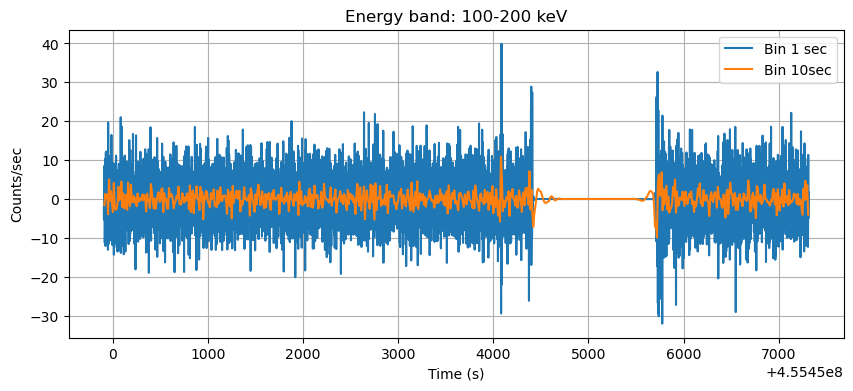

In [10]:
import pywt
def wavelet_denoise(signal, wavelet='db4', level=3):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    denoised_coeffs = [coeffs[0]]  
    for c in coeffs[1:]:
        denoised_coeffs.append(pywt.threshold(c, uthresh, mode='soft'))
    return pywt.waverec(denoised_coeffs, wavelet)

for (emin, emax) in energy_bands:
    mask = (energy_q0 > emin) & (energy_q0 < emax)
    times_filtered = times_q0[mask]
    x0, cps_q0 = counts_per_sec(times_filtered, bin_width=1)
    x0t, cps_q0_t = counts_per_sec(times_filtered, bin_width=10)
    cps_denoised = wavelet_denoise(cps_q0)
    cpst_denoised = wavelet_denoise(cps_q0_t)
    de = cps_q0[:len(cps_denoised)] - cps_denoised
    cpst_denoised = cpst_denoised[:len(cps_q0_t)]
    det = cps_q0_t - cpst_denoised


    plt.figure(figsize=(10, 4))
    plt.plot(x0,de,label='Bin 1 sec')
    plt.plot(x0t,det,label='Bin 10sec')
    plt.title(f"Energy band: {emin}-{emax} keV")
    plt.xlabel("Time (s)")
    plt.ylabel("Counts/sec")
    plt.grid()
    plt.legend()
    plt.show()


##### Out of all the filters tried the best probably would be the Median Filter but i will also be using matched filter for better understanding of how is SNR 

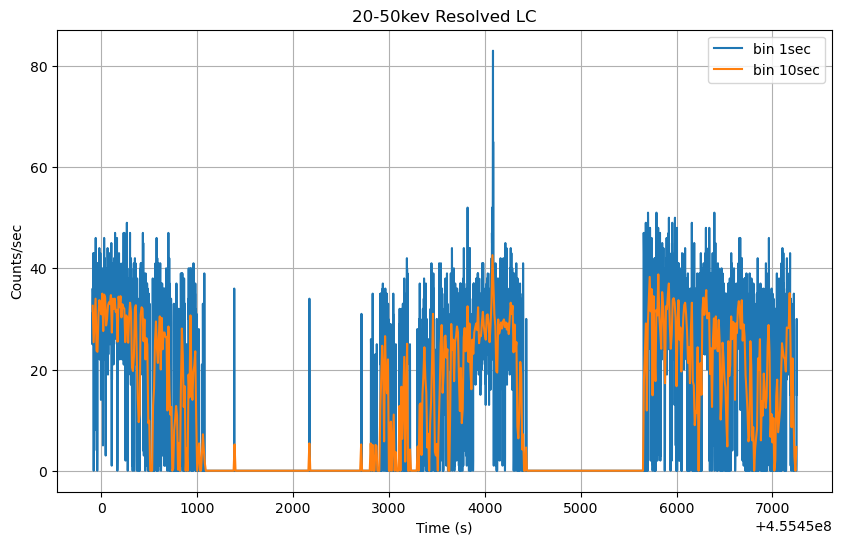

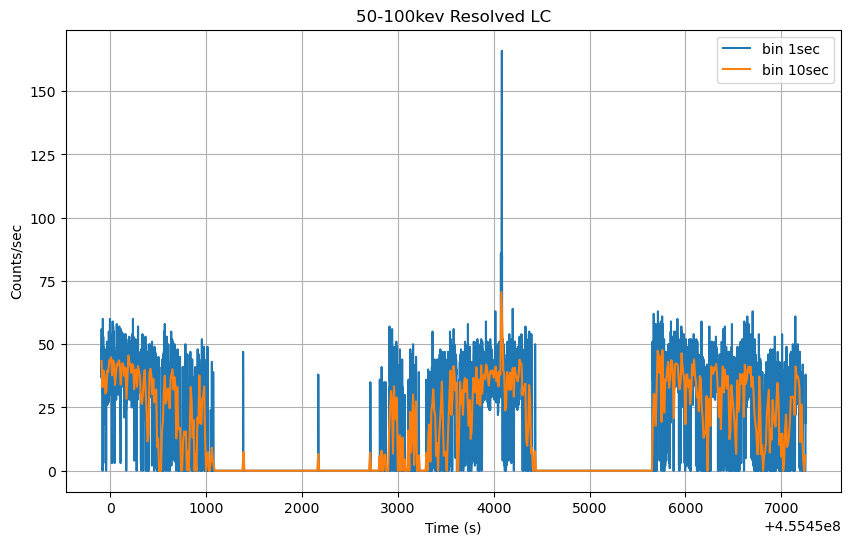

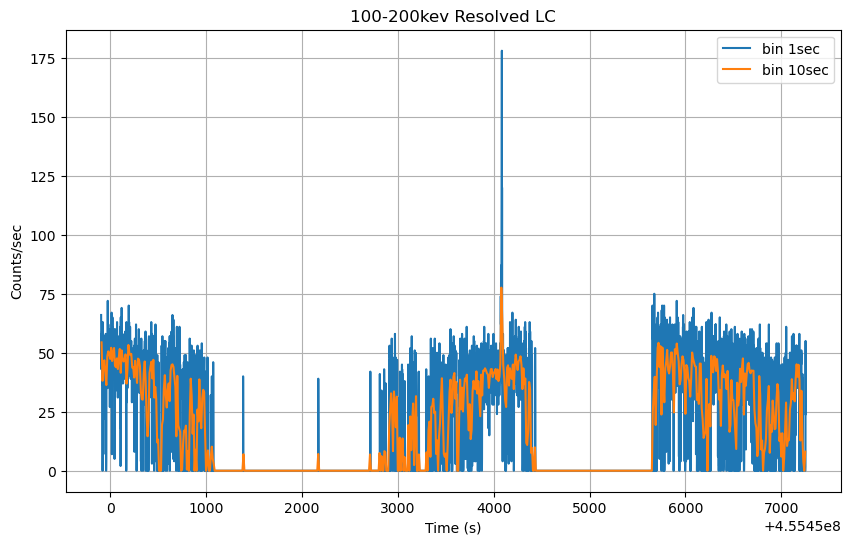

In [11]:
energy_q1 = q1.data["ENERGY"]
energy_bands = [(20,50),(50,100),(100,200)]
for (emin,emax) in energy_bands:
    mask = (energy_q1 > emin) & (energy_q1 < emax)
    times_filtered = times_q1[mask] 
    x1, cps_q1 = counts_per_sec(times_filtered, bin_width=1)
    x1t, cps_q1_t = counts_per_sec(times_filtered, bin_width=10)
    plt.figure(figsize=(10, 6))
    plt.plot(x1, cps_q1,label='bin 1sec')
    plt.plot(x1t, cps_q1_t,label='bin 10sec')
    plt.xlabel('Time (s)')
    plt.ylabel('Counts/sec')
    plt.title(f"{emin}-{emax}kev Resolved LC")
    plt.grid(True)
    plt.legend()
    plt.show()

<Figure size 1000x600 with 0 Axes>

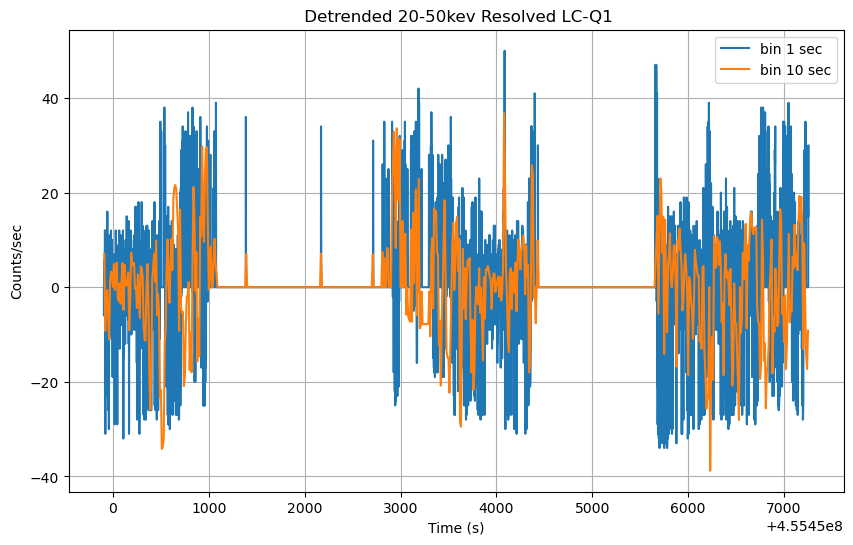

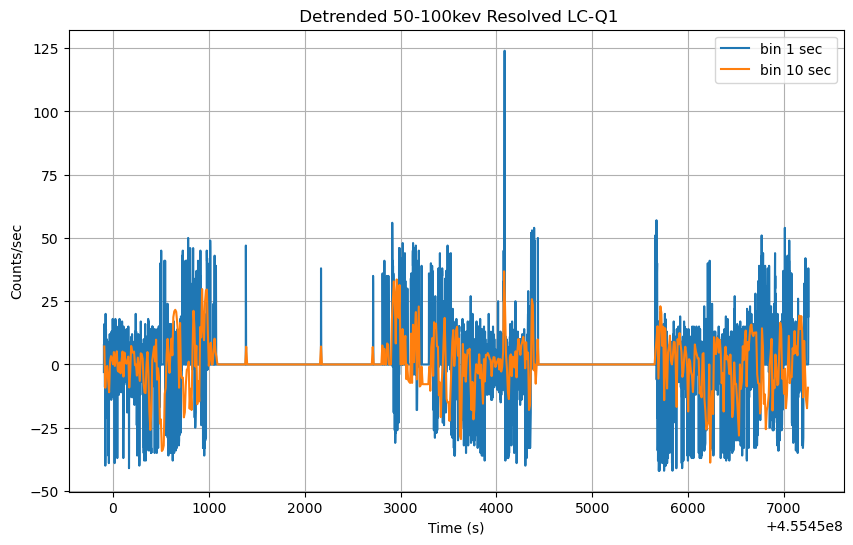

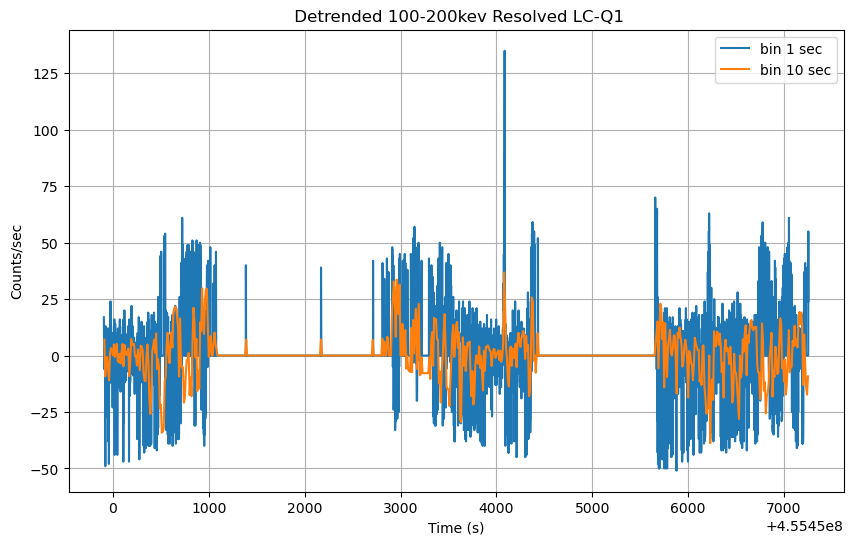

In [12]:
energy_bands = [(20, 50), (50, 100), (100, 200)]
plt.figure(figsize=(10, 6))

for (emin, emax) in energy_bands:
    mask = (energy_q1 > emin) & (energy_q1 < emax)
    times_filtered1 = times_q1[mask] 
    x1, cps_q1 = counts_per_sec(times_filtered1, bin_width=1)
    plt.figure(figsize=(10, 6))
    med1 = median_filter(cps_q1,size=59)
    med12 = median_filter(cps_q1_t,size=59)
    detrend1 = cps_q1 - med1
    detrend12 = cps_q1_t - med12
    plt.plot(x1,detrend1,label='bin 1 sec')
    plt.plot(x1t,detrend12,label='bin 10 sec')
    plt.xlabel('Time (s)')
    plt.ylabel('Counts/sec')
    plt.title(f" Detrended {emin}-{emax}kev Resolved LC-Q1")
    plt.grid(True)
    plt.legend()
    plt.show()

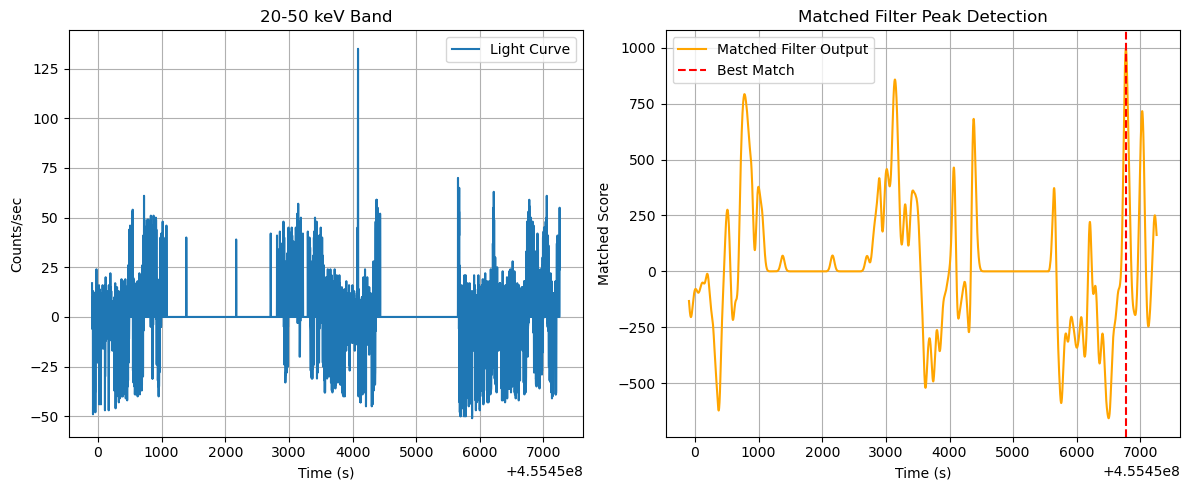

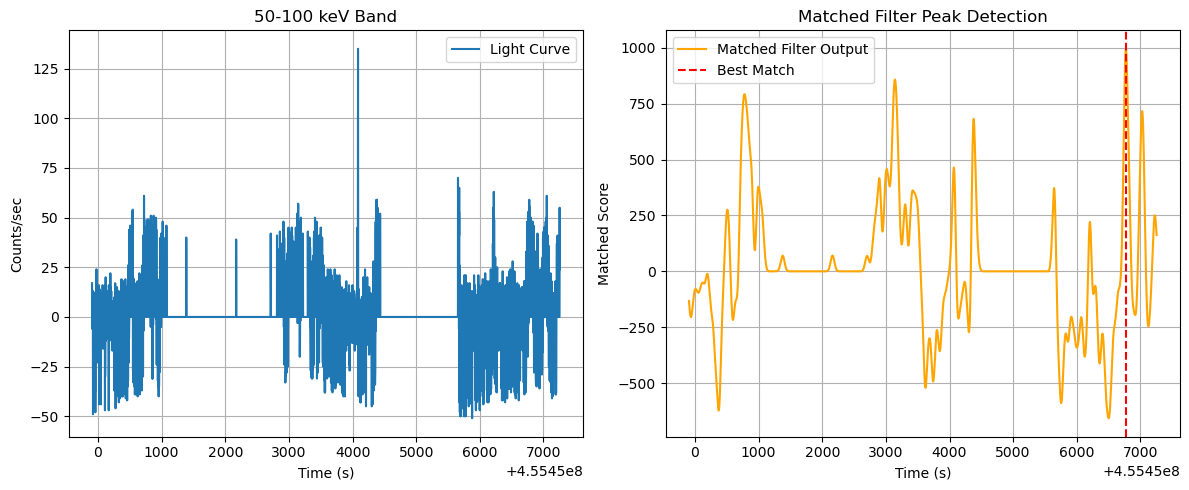

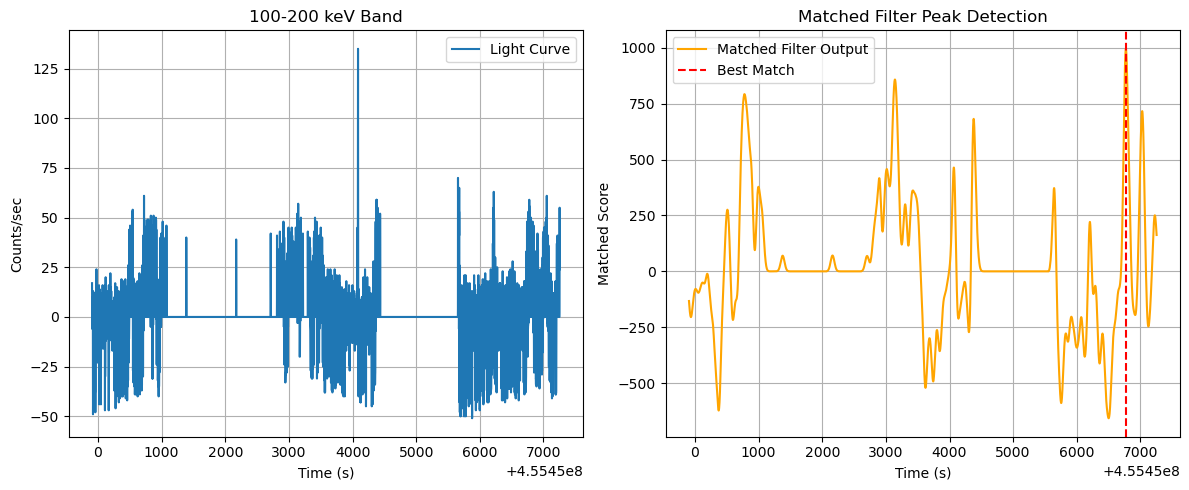

In [13]:
from scipy.signal import correlate
template_center = 1
template_width = 3
template_time = np.linspace(-10, 10, 200)
template = np.exp(-0.5 * ((template_time - template_center)/template_width)**2)

for (emin, emax) in energy_bands:
    mask = (energy_q1 > emin) & (energy_q1 < emax)
    times_filtered1 = times_q1[mask]
    matched1 = correlate(detrend1, template, mode='same')
    matched1 /= np.max(matched)  #
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x1,detrend1 , label='Light Curve')
    plt.xlabel("Time (s)")
    plt.ylabel("Counts/sec")
    plt.title(f"{emin}-{emax} keV Band")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(x1, matched1, label='Matched Filter Output', color='orange')
    plt.axvline(x1[np.argmax(matched1)], color='red', linestyle='--', label='Best Match')
    plt.xlabel("Time (s)")
    plt.ylabel("Matched Score")
    plt.title("Matched Filter Peak Detection")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

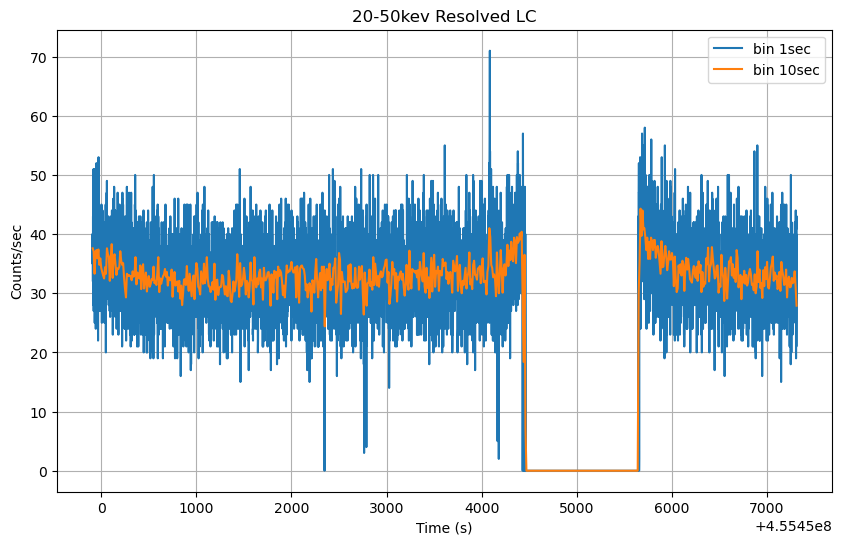

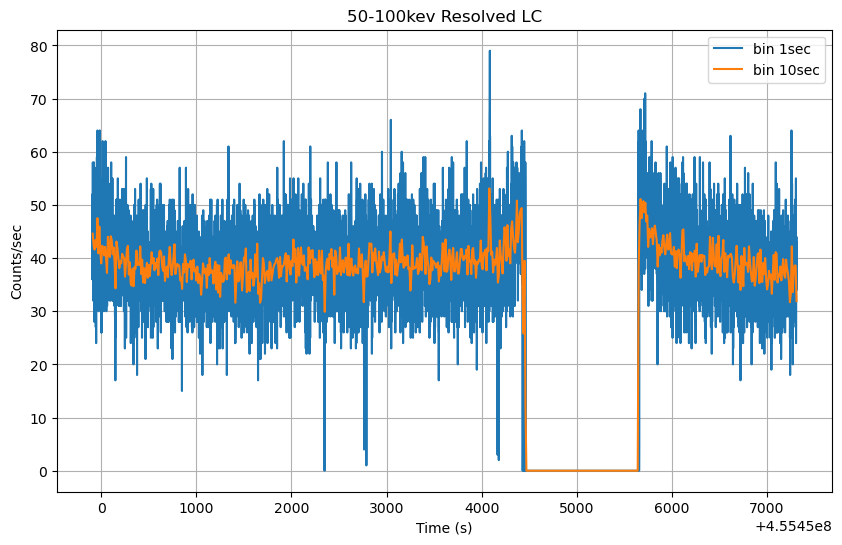

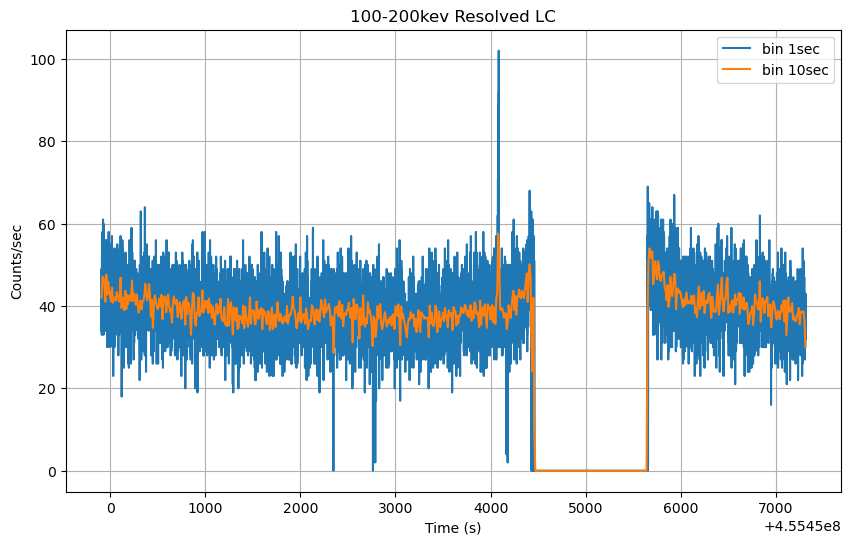

In [14]:
energy_q2 = q2.data["ENERGY"]
energy_bands = [(20,50),(50,100),(100,200)]
for (emin,emax) in energy_bands:
    mask = (energy_q2 > emin) & (energy_q2 < emax)
    times_filtered = times_q2[mask] 
    x2, cps_q2 = counts_per_sec(times_filtered, bin_width=1)
    x2t, cps_q2t = counts_per_sec(times_filtered, bin_width=10)
    plt.figure(figsize=(10, 6))
    plt.plot(x2, cps_q2,label='bin 1sec')
    plt.plot(x2t, cps_q2t,label='bin 10sec')
    plt.xlabel('Time (s)')
    plt.ylabel('Counts/sec')
    plt.title(f"{emin}-{emax}kev Resolved LC")
    plt.grid(True)
    plt.legend()
    plt.show()

<Figure size 1000x600 with 0 Axes>

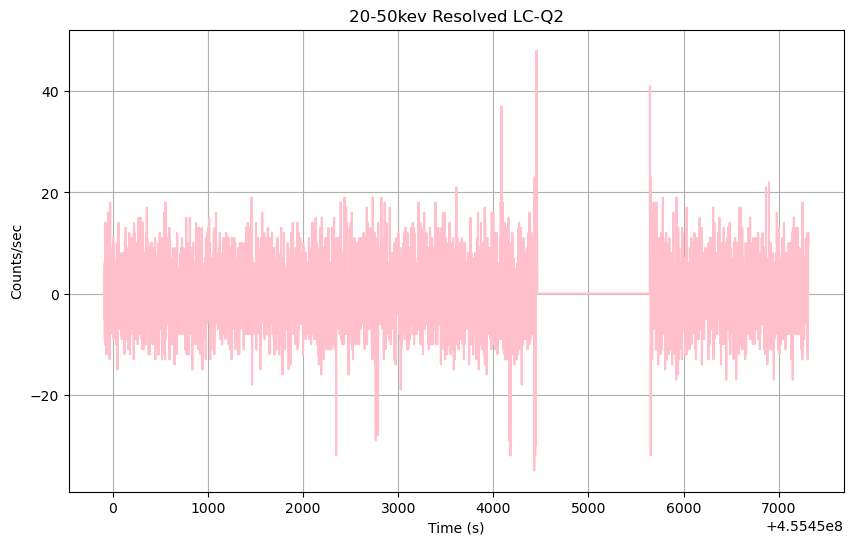

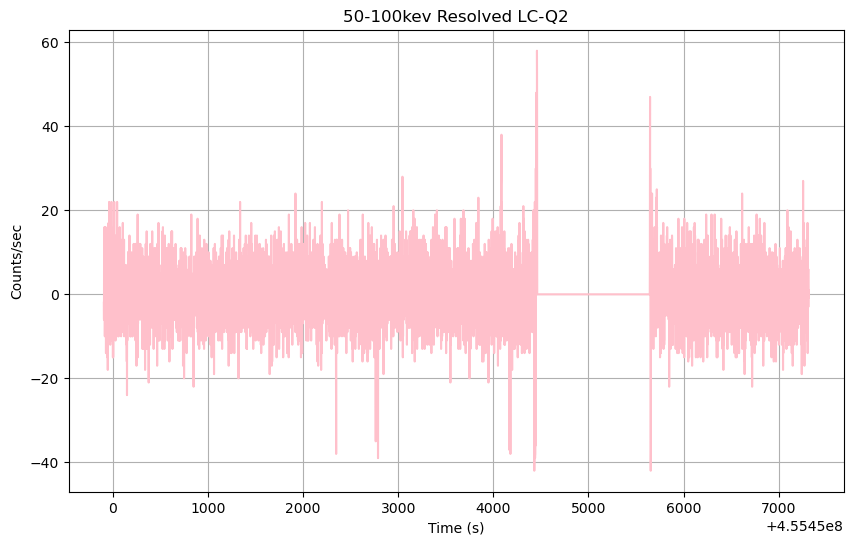

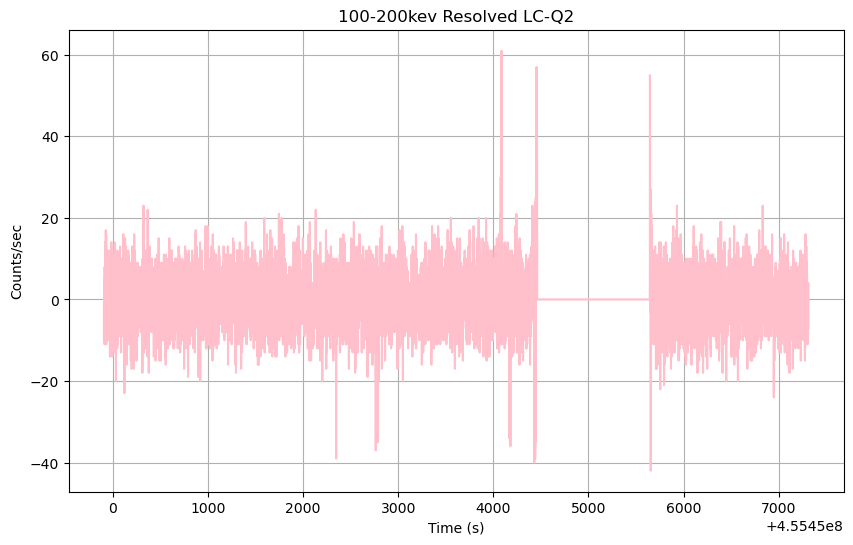

In [15]:
energy_bands = [(20, 50), (50, 100), (100, 200)]
plt.figure(figsize=(10, 6))

for (emin, emax) in energy_bands:
    mask = (energy_q2 > emin) & (energy_q2 < emax)
    times_filtered2 = times_q2[mask] 
    x2, cps_q2 = counts_per_sec(times_filtered2, bin_width=1)
    plt.figure(figsize=(10, 6))
    
    med2 = median_filter(cps_q2,size=101)
    de2 = cps_q2 - med2
    plt.plot(x2,de2,color='pink')
    
    plt.xlabel('Time (s)')
    plt.ylabel('Counts/sec')
    plt.title(f"{emin}-{emax}kev Resolved LC-Q2")
    plt.grid(True)
    plt.show()

<Figure size 1000x600 with 0 Axes>

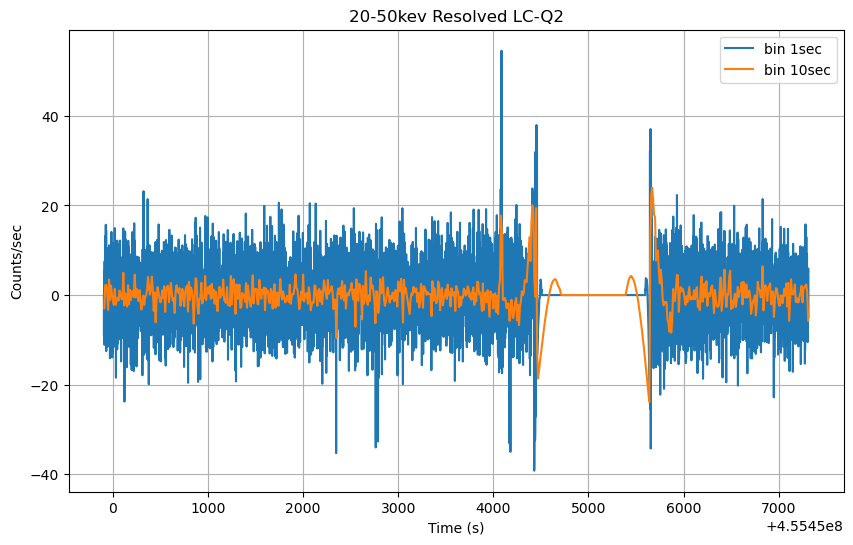

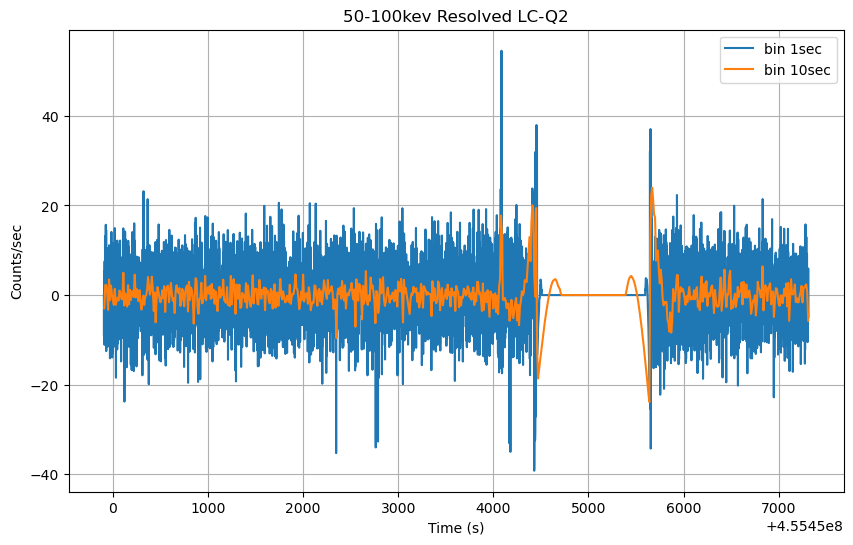

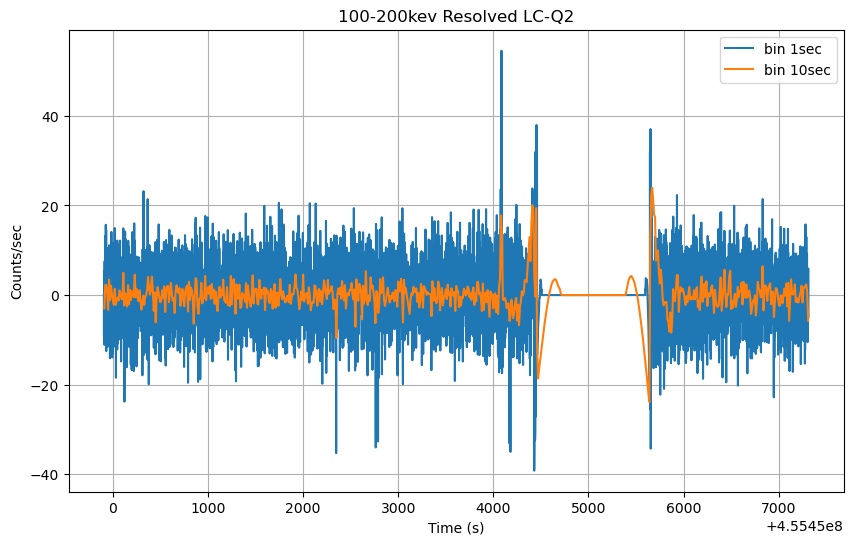

In [16]:
energy_bands = [(20, 50), (50, 100), (100, 200)]
plt.figure(figsize=(10, 6))

for (emin, emax) in energy_bands:
    mask = (energy_q2 > emin) & (energy_q2 < emax)
    times_filtered2 = times_q2[mask] 
    plt.figure(figsize=(10, 6))
    sav2 = savgol_filter(cps_q2, window_length=101, polyorder=3)
    sav21 = savgol_filter(cps_q2t, window_length=51, polyorder=3)
    detrend2 = cps_q2 - sav2
    detrend21 = cps_q2t - sav21
    plt.plot(x2,detrend2,label='bin 1sec')
    plt.plot(x2t,detrend21,label='bin 10sec')
    
    plt.xlabel('Time (s)')
    plt.ylabel('Counts/sec')
    plt.title(f"{emin}-{emax}kev Resolved LC-Q2")
    plt.grid(True)
    plt.legend()
    plt.show()

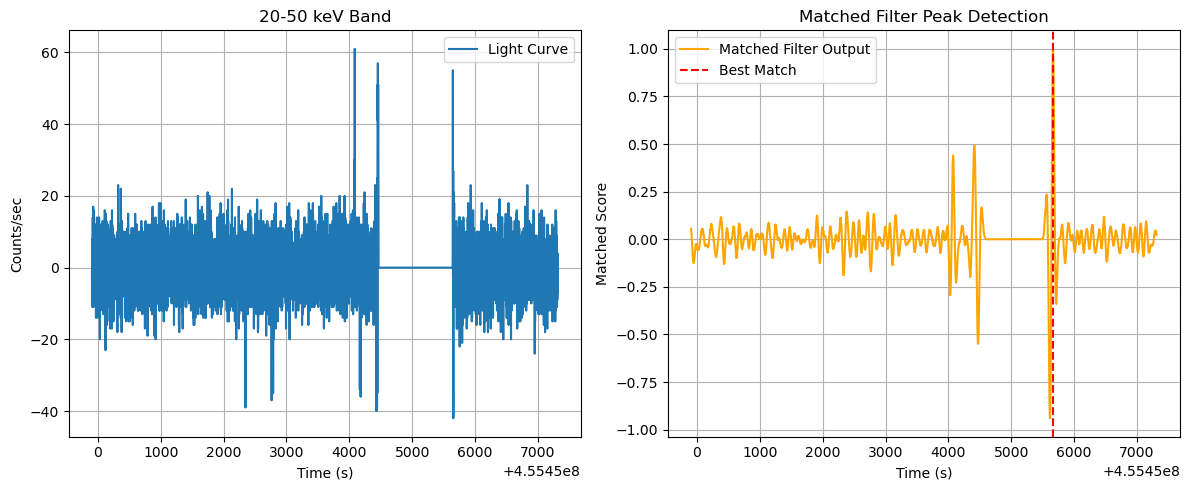

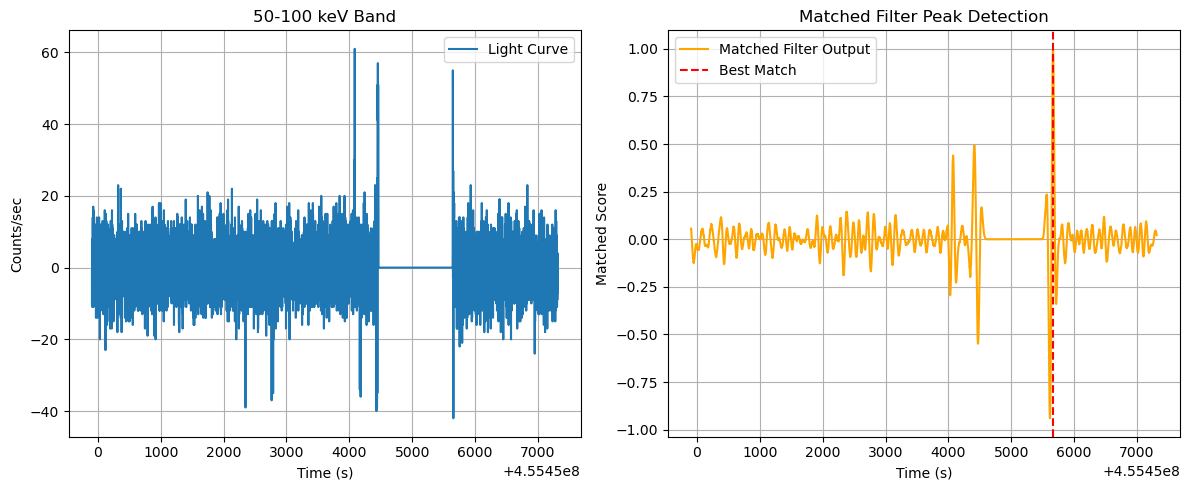

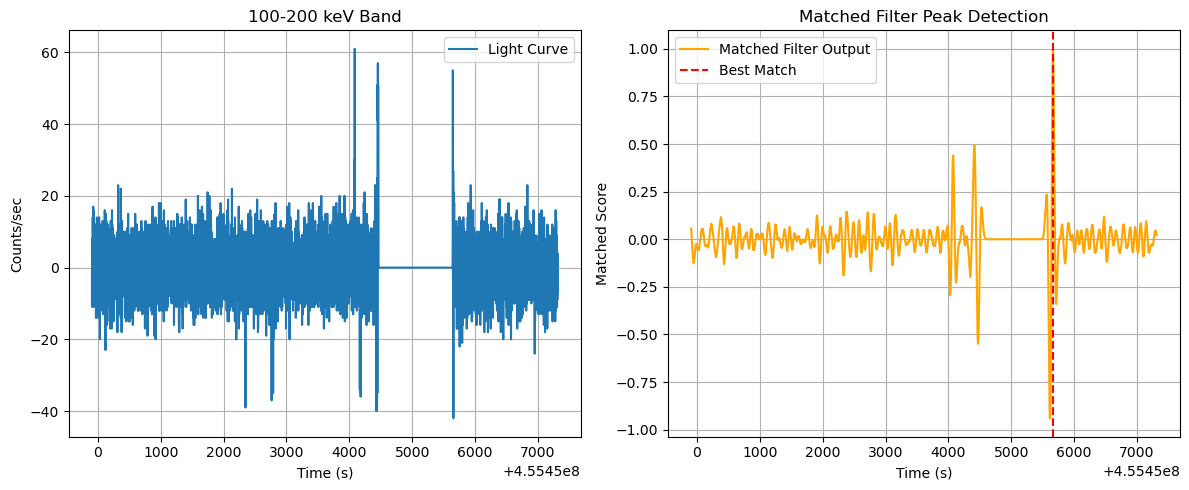

In [17]:
template_center = 1
template_width = 3
template_time = np.linspace(-10, 10, 200)
template = np.exp(-0.5 * ((template_time - template_center)/template_width)**2)

for (emin, emax) in energy_bands:
    mask = (energy_q2 > emin) & (energy_q2 < emax)
    times_filtered2 = times_q2[mask]
    x2, cps_q2 = counts_per_sec(times_filtered2, bin_width=1)
    
    matched2 = correlate(detrend2, template, mode='same')
    matched2 /= np.max(matched2)  #
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x2, de2, label='Light Curve')
    plt.xlabel("Time (s)")
    plt.ylabel("Counts/sec")
    plt.title(f"{emin}-{emax} keV Band")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(x2, matched2, label='Matched Filter Output', color='orange')
    plt.axvline(x2[np.argmax(matched2)], color='red', linestyle='--', label='Best Match')
    plt.xlabel("Time (s)")
    plt.ylabel("Matched Score")
    plt.title("Matched Filter Peak Detection")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

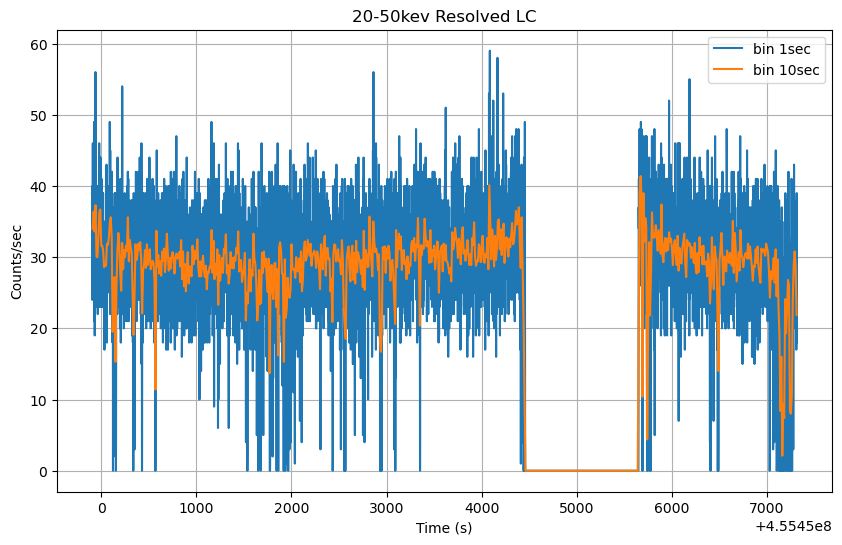

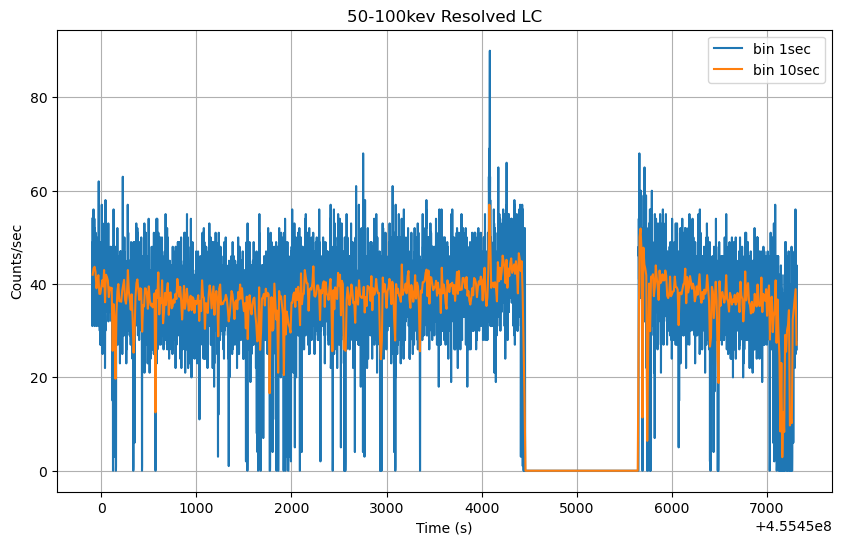

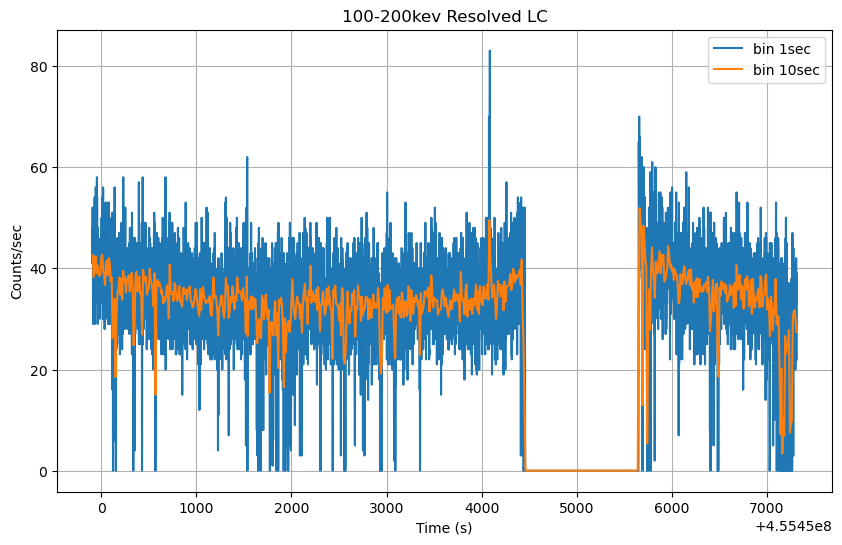

In [18]:
energy_q3 = q3.data["ENERGY"]
energy_bands = [(20,50),(50,100),(100,200)]
for (emin,emax) in energy_bands:
    mask = (energy_q3 > emin) & (energy_q3 < emax)
    times_filtered = times_q3[mask] 
    x3, cps_q3 = counts_per_sec(times_filtered, bin_width=1)
    x3t, cps_q3t = counts_per_sec(times_filtered, bin_width=10)
    plt.figure(figsize=(10, 6))
    plt.plot(x3, cps_q3,label='bin 1sec')
    plt.plot(x3t, cps_q3t,label='bin 10sec')
    plt.xlabel('Time (s)')
    plt.ylabel('Counts/sec')
    plt.title(f"{emin}-{emax}kev Resolved LC")
    plt.grid(True)
    plt.legend()
    plt.show()

<Figure size 1000x600 with 0 Axes>

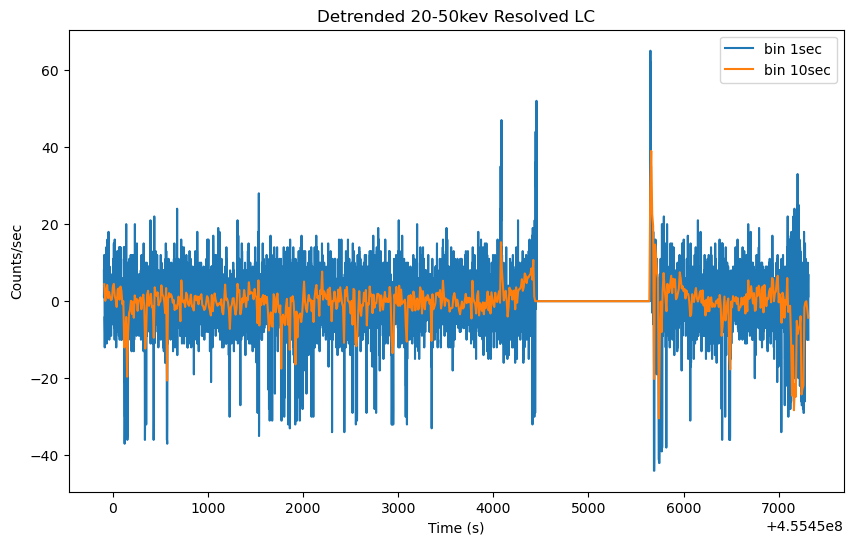

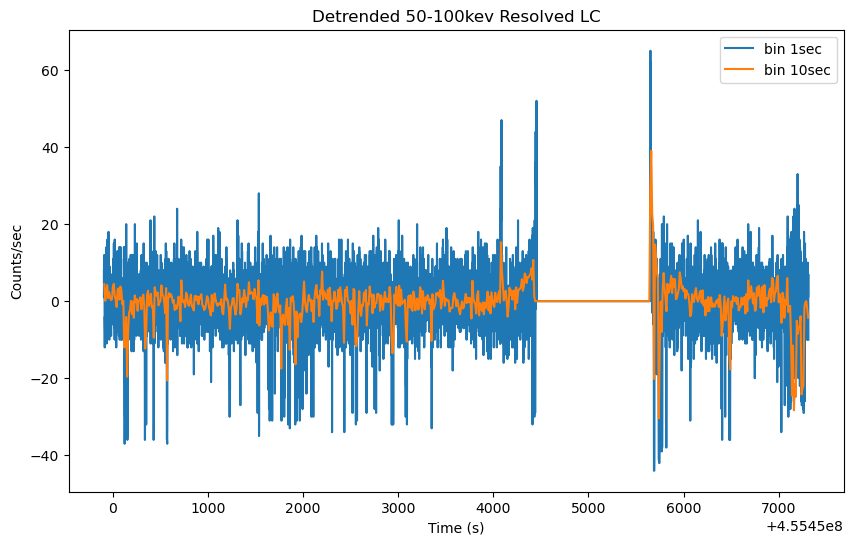

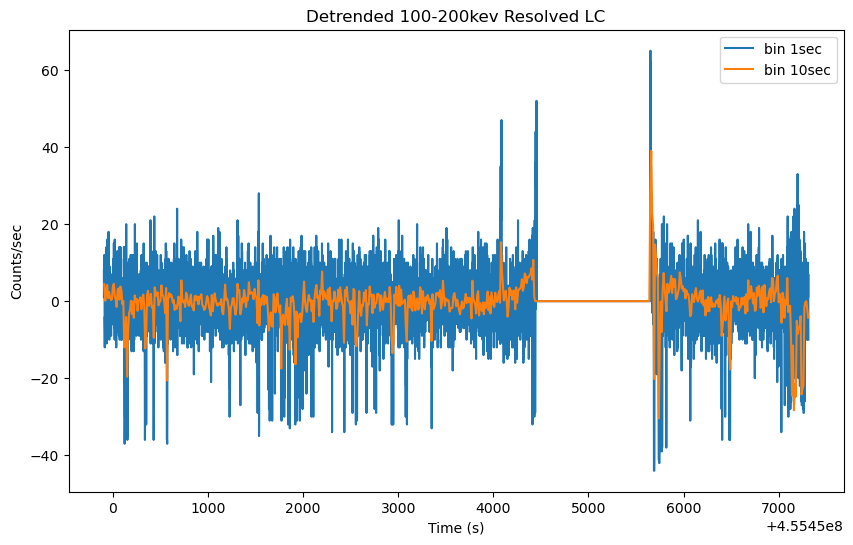

In [19]:
energy_bands = [(20, 50), (50, 100), (100, 200)]
plt.figure(figsize=(10, 6))

for (emin, emax) in energy_bands:
    mask = (energy_q3 > emin) & (energy_q3 < emax)
    plt.figure(figsize=(10, 6))
    med3 = median_filter(cps_q3,size=101)
    med31 = median_filter(cps_q3t,size=101)
    detrend3 = cps_q3-med3
    detrend31 = cps_q3t-med31
    plt.plot(x3,detrend3,label='bin 1sec')
    plt.plot(x3t,detrend31,label='bin 10sec')
    plt.xlabel('Time (s)')
    plt.ylabel('Counts/sec')
    plt.title(f"Detrended {emin}-{emax}kev Resolved LC")
    plt.legend()
    plt.show()

<Figure size 1000x600 with 0 Axes>

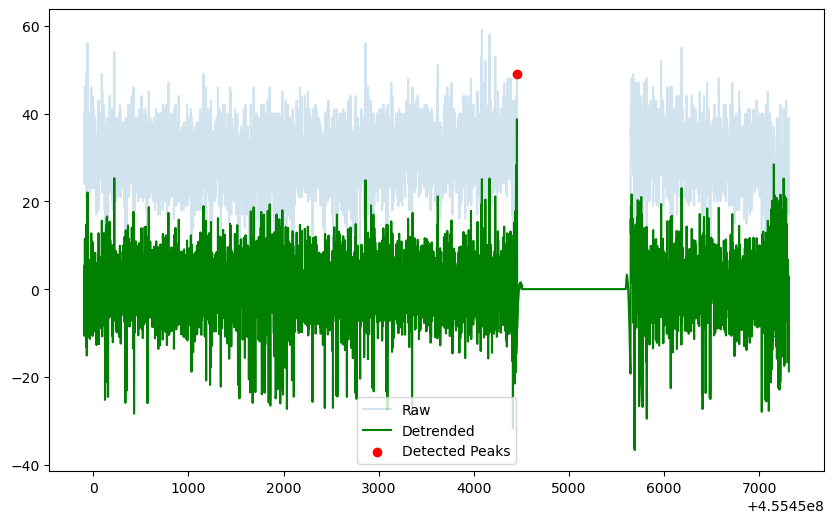

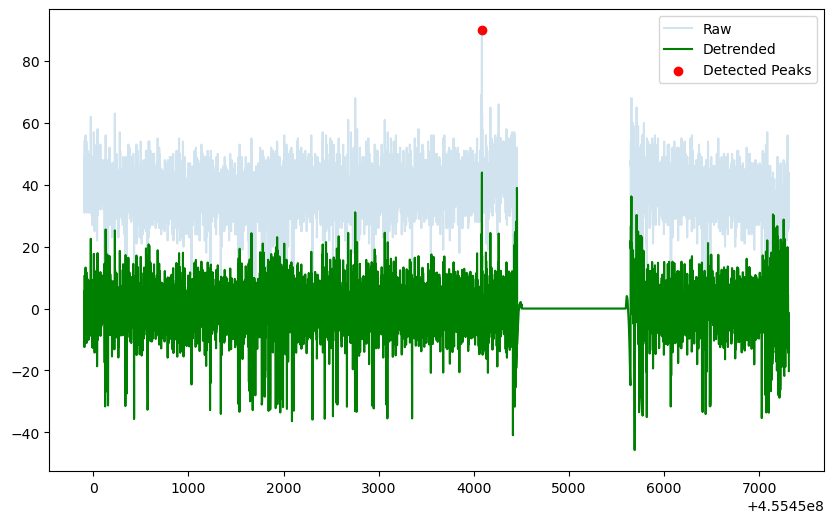

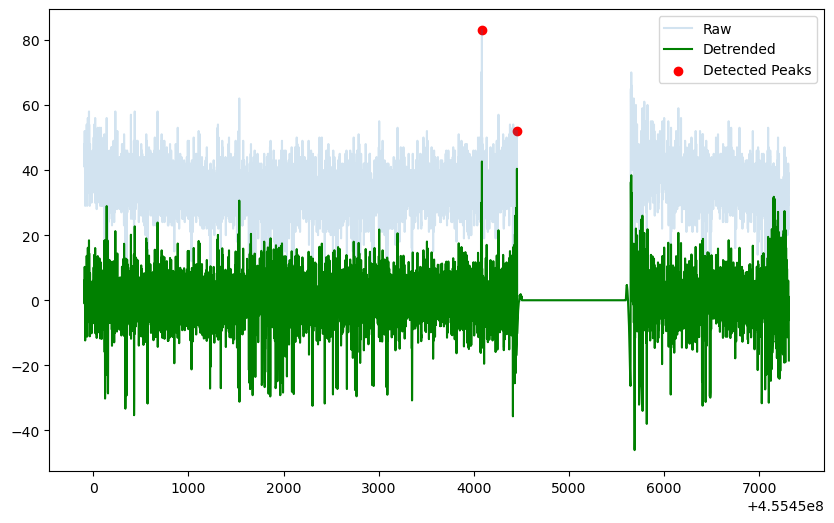

In [20]:
energy_bands = [(20, 50), (50, 100), (100, 200)]
plt.figure(figsize=(10, 6))

for (emin, emax) in energy_bands:
    mask = (energy_q3 > emin) & (energy_q3 < emax)
    times_filtered3 = times_q3[mask] 
    x3, cps_q3 = counts_per_sec(times_filtered3, bin_width=1)
    plt.figure(figsize=(10, 6))
    sav3= savgol_filter(cps_q3,window_length=101,polyorder=2)
    detrend3 = cps_q3-sav3
    threshold = np.mean(detrend3) + 5 * np.std(detrend3)
    peaks = np.where(detrend3 > threshold)[0]
    plt.plot(x3, cps_q3, label="Raw", alpha=0.2)
    plt.plot(x3, detrend3, label="Detrended", color='green')
    plt.scatter(x3[peaks], cps_q3[peaks], color='red', label="Detected Peaks")
    plt.legend()
    plt.show()

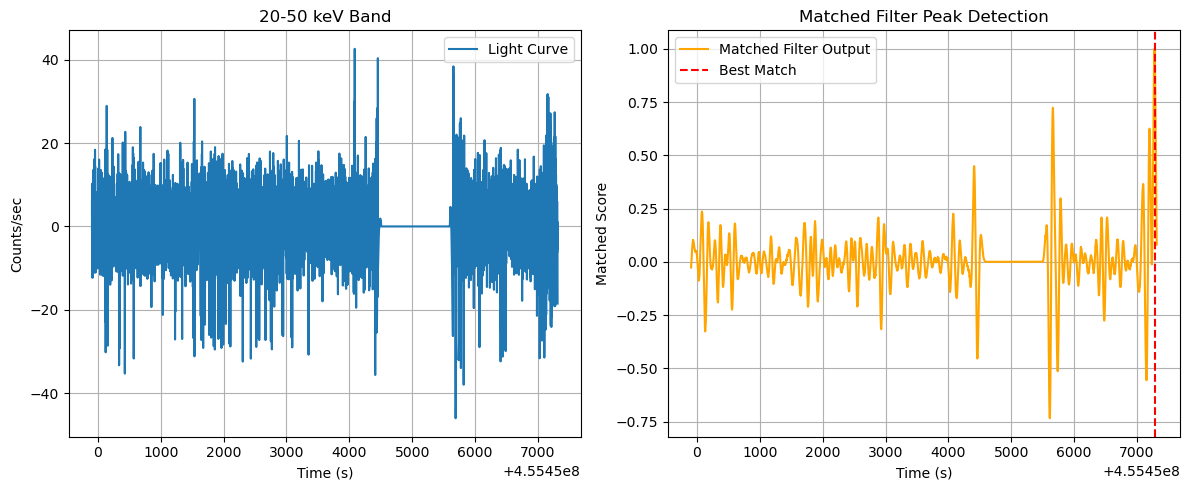

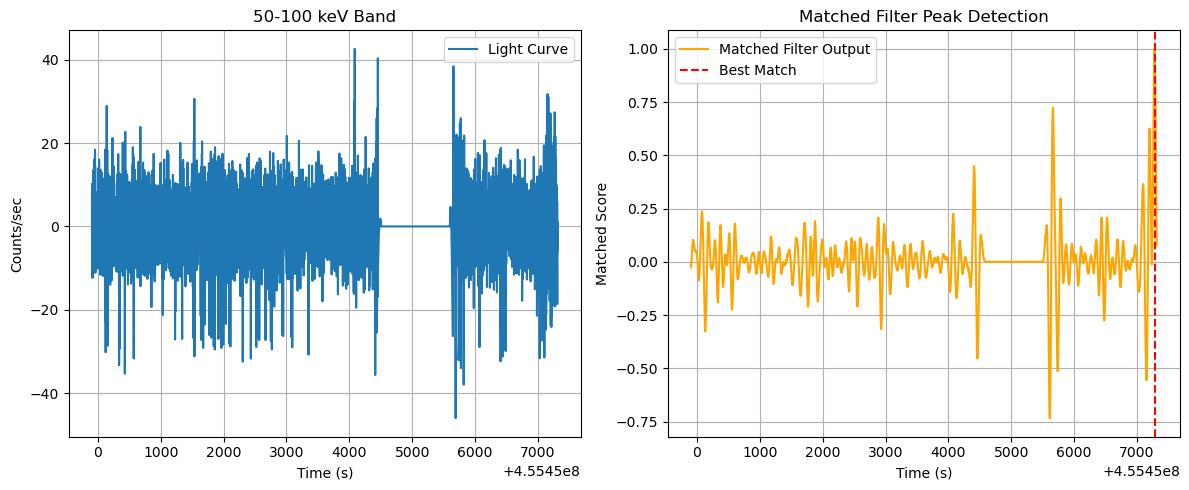

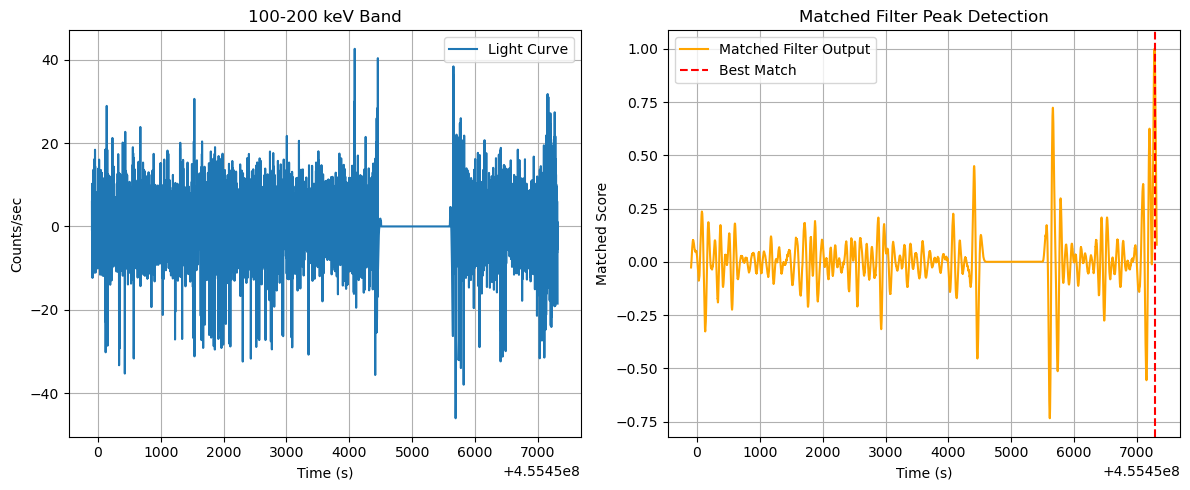

In [21]:
template_center = 1
template_width = 3
template_time = np.linspace(-10, 10, 200)
template = np.exp(-0.5 * ((template_time - template_center)/template_width)**2)

for (emin, emax) in energy_bands:
    mask = (energy_q3 > emin) & (energy_q3 < emax)
    times_filtered3 = times_q3[mask]
    x3, cps_q3 = counts_per_sec(times_filtered3, bin_width=1)
    
    matched3 = correlate(detrend3, template, mode='same')
    matched3 /= np.max(matched3)  #
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x3, detrend3, label='Light Curve')
    plt.xlabel("Time (s)")
    plt.ylabel("Counts/sec")
    plt.title(f"{emin}-{emax} keV Band")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(x3, matched3, label='Matched Filter Output', color='orange')
    plt.axvline(x3[np.argmax(matched3)], color='red', linestyle='--', label='Best Match')
    plt.xlabel("Time (s)")
    plt.ylabel("Matched Score")
    plt.title("Matched Filter Peak Detection")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

In [22]:
veto.columns

ColDefs(
    name = 'Time'; format = 'D'; unit = 's'
    name = 'CZTSECCNT'; format = 'D'; unit = 's'
    name = 'VetoSpec'; format = '256I'; bscale = 1; bzero = 32768
    name = 'QuadID'; format = 'B'
)

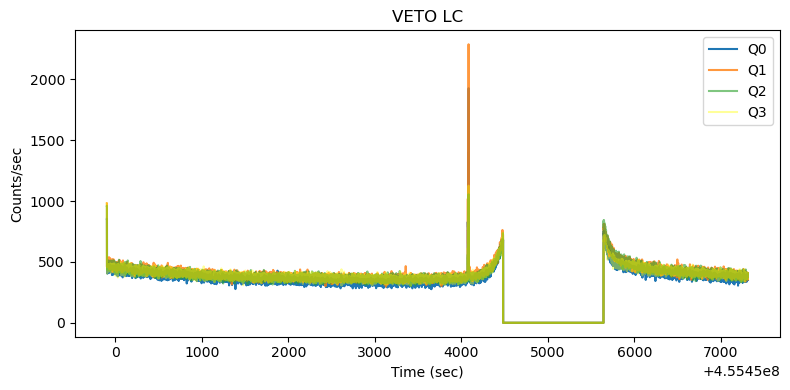

In [24]:
vetospec = veto.data['VetoSpec']
vetotimes = veto.data['Time']
quad = veto.data['QuadID']
Gains = [5.591, 5.594, 5.943, 5.222]
Offsets = [-56.741, -41.239, -41.682, -26.528]
energyv = [(100,200),(200,500)]


def cps_veto(times, bin_width, counts):
    time_min = times.min()
    time_max = times.max()
    bins = np.arange(time_min, time_max + bin_width, bin_width)
    binned_counts, _ = np.histogram(times, bins=bins, weights=counts)
    bin_centers = bins[:-1] + bin_width / 2
    return bin_centers, binned_counts / bin_width

plt.figure(figsize=(8,4))

times_v = []
counts_v=[]
for q in range(4):
    gain = Gains[q]
    offset = Offsets[q]

    idx = (quad == q)
    v_spec_q = vetospec[idx]
    times_q = vetotimes[idx] 

    channels = np.arange(256)
    energies = channels * gain + offset
    counts_q = np.sum(v_spec_q, axis=1)
    counts_v.append(counts_q)
    times_v.append(times_q)
    
    
xv, cps_vals = cps_veto(times_v[0],1, counts_v[0])
xv1, cps_vals1 = cps_veto(times_v[1],1, counts_v[1])
xv2, cps_vals2 = cps_veto(times_v[2],1, counts_v[2])
xv3, cps_vals3 = cps_veto(times_v[3],1, counts_v[3])
plt.plot(xv, cps_vals, drawstyle='steps-mid',label='Q0')
plt.plot(xv1, cps_vals1, drawstyle='steps-mid',label='Q1',alpha=0.8)
plt.plot(xv2, cps_vals2, drawstyle='steps-mid',label='Q2',alpha=0.6)
plt.plot(xv3, cps_vals3, drawstyle='steps-mid',label='Q3',alpha=0.4,color='yellow')
plt.title(f"VETO LC")
plt.xlabel('Time (sec)')
plt.ylabel('Counts/sec')
plt.legend()
plt.tight_layout()
plt.show()

    

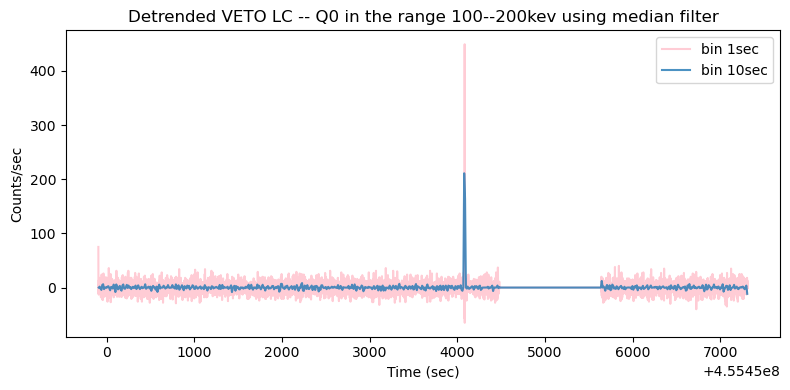

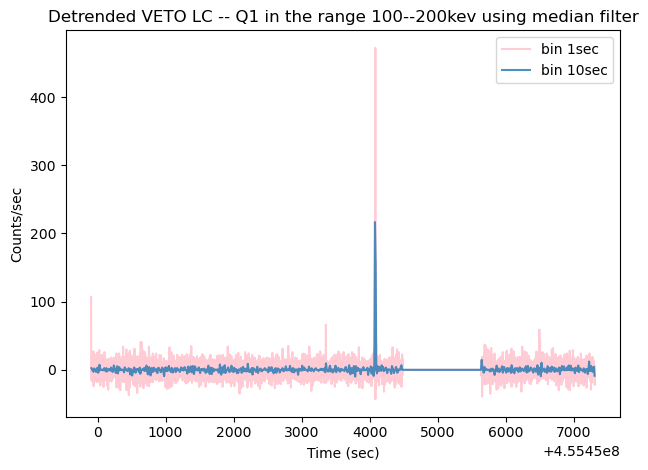

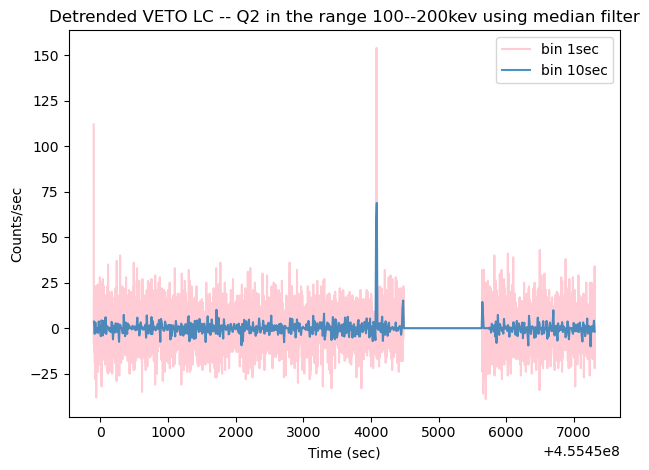

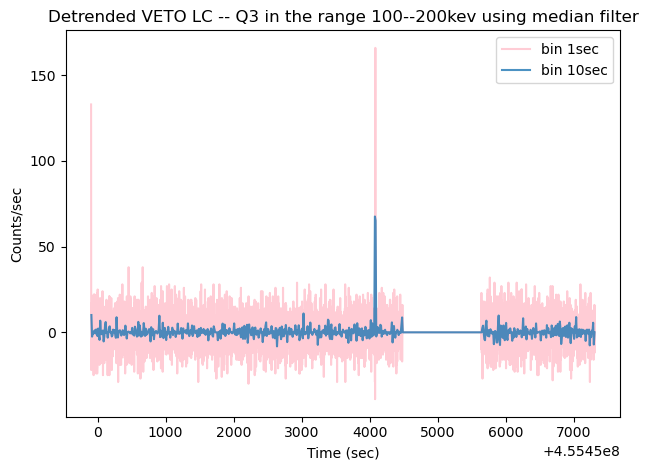

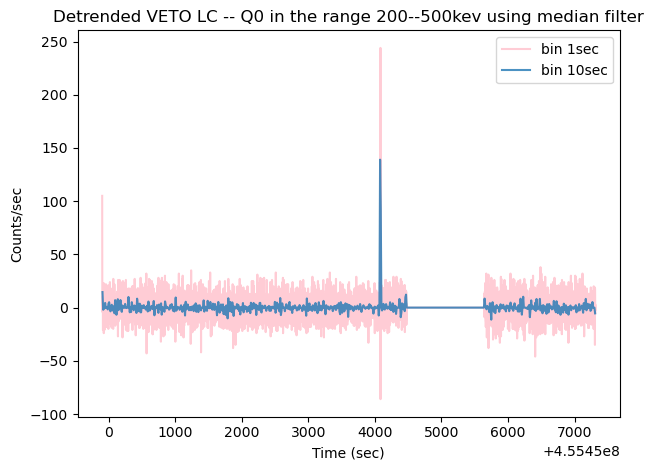

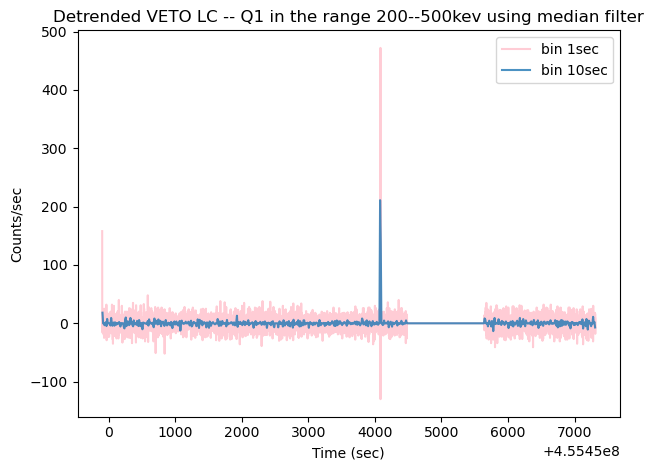

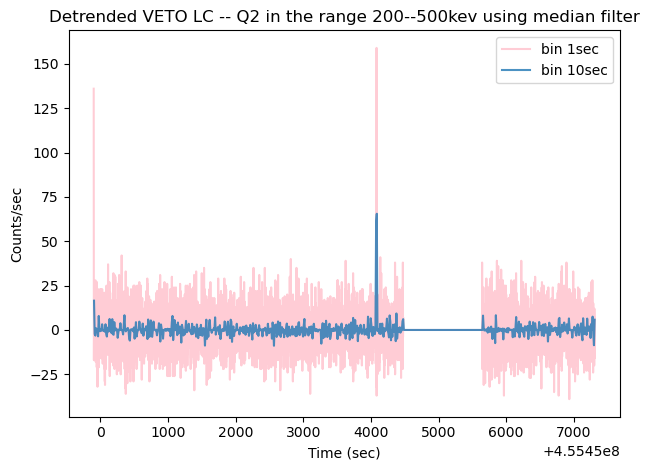

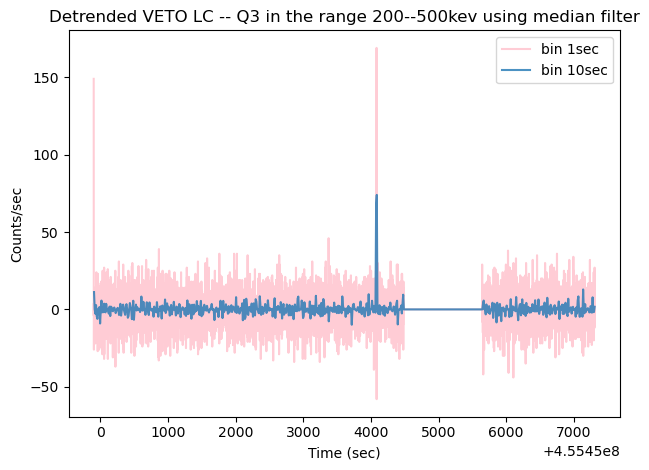

In [25]:
plt.figure(figsize=(8,4))
bin_width=1
for (emin, emax) in energyv:
    for q in range(4):
        idx = (quad == q)
        v_spec_q = vetospec[idx]
        times_q = vetotimes[idx]
        channels = np.arange(256)
        energies = channels * gain + offset
        mask = (energies >= emin) & (energies <= emax)

        counts_q = np.sum(v_spec_q[:, mask], axis=1)
        xv, cps_vals = cps_veto(times_q,1, counts_q)
        xv1, cps_vals1 = cps_veto(times_q,10, counts_q)
        med= median_filter(cps_vals,size=5)
        med1= median_filter(cps_vals1,size=5)
        demed=cps_vals-med
        demed1 = cps_vals1-med1
        plt.plot(xv,demed,alpha=0.8,color='pink',label='bin 1sec')
        plt.plot(xv1,demed1,alpha=0.8,label='bin 10sec')
       
        plt.title(f"Detrended VETO LC -- Q{q} in the range {emin}--{emax}kev using median filter")
        plt.xlabel('Time (sec)')
        plt.ylabel('Counts/sec')
        plt.tight_layout()
        plt.legend()
        plt.show()

#### Veto has a clear deduction of a GRB peak even though without denoising the peak is pretty much clearly visible 

## Detecting the actual GRB using N sigma algorthim

Peak at 455454083.51 sec, value = 79.00 cps
Peak at 455454085.51 sec, value = 114.00 cps
Peak at 455454087.51 sec, value = 80.00 cps
Peak at 455454398.51 sec, value = 39.00 cps
Peak at 455454408.51 sec, value = 44.00 cps
Peak at 455455727.51 sec, value = 39.00 cps
Peak at 455455731.51 sec, value = 56.00 cps


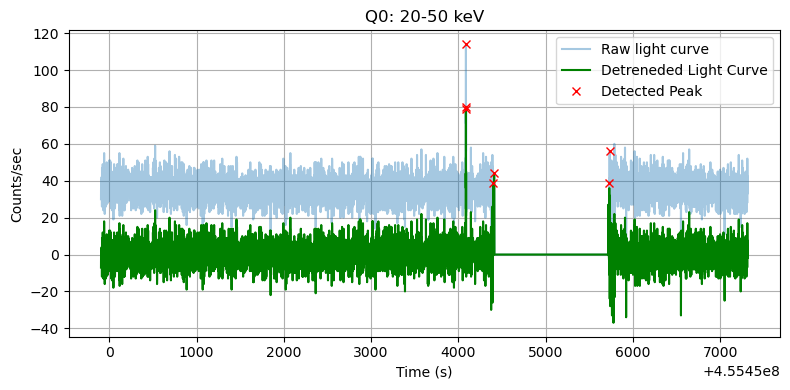

Peak at 455454075.54 sec, value = 78.00 cps
Peak at 455454083.54 sec, value = 102.00 cps
Peak at 455454085.54 sec, value = 143.00 cps
Peak at 455454087.54 sec, value = 91.00 cps
Peak at 455454397.54 sec, value = 51.00 cps
Peak at 455454408.54 sec, value = 42.00 cps
Peak at 455455714.54 sec, value = 51.00 cps
Peak at 455455726.54 sec, value = 46.00 cps


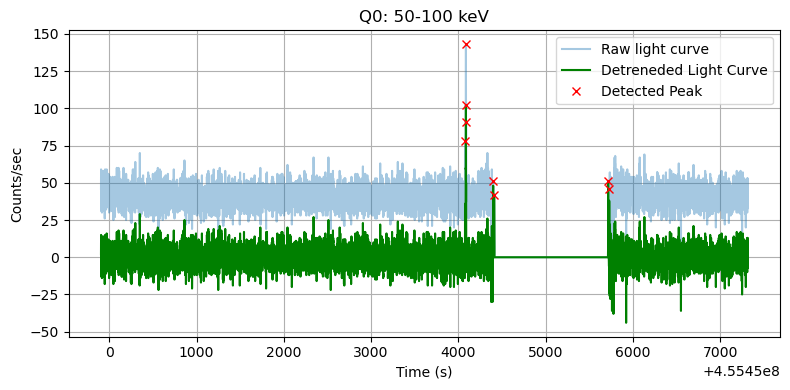

Peak at 455454076.51 sec, value = 75.00 cps
Peak at 455454083.51 sec, value = 111.00 cps
Peak at 455454085.51 sec, value = 133.00 cps
Peak at 455454397.51 sec, value = 55.00 cps
Peak at 455454408.51 sec, value = 43.00 cps
Peak at 455455714.51 sec, value = 45.00 cps
Peak at 455455726.51 sec, value = 69.00 cps


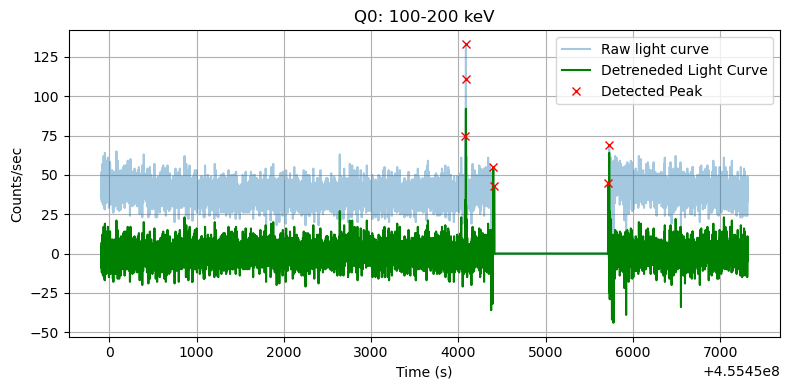

Peak at 455454080.01 sec, value = 50.70 cps


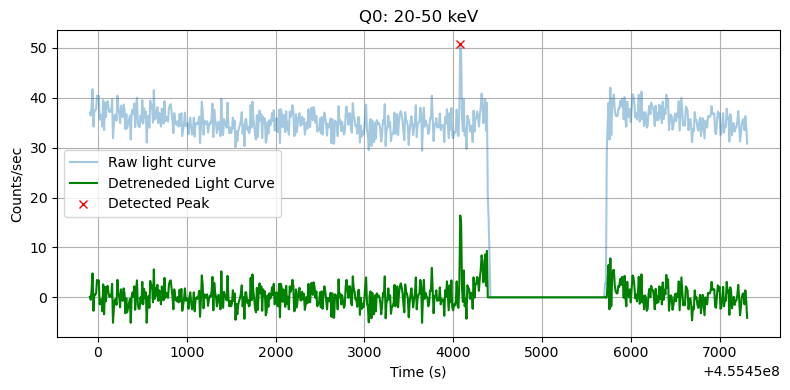

Peak at 455454080.04 sec, value = 68.50 cps


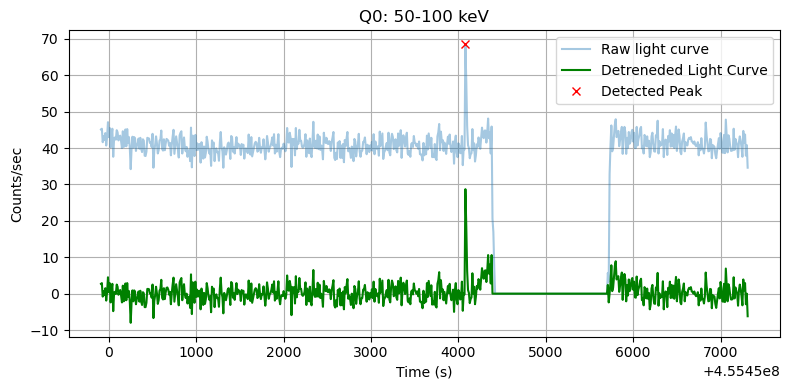

Peak at 455454080.01 sec, value = 66.90 cps


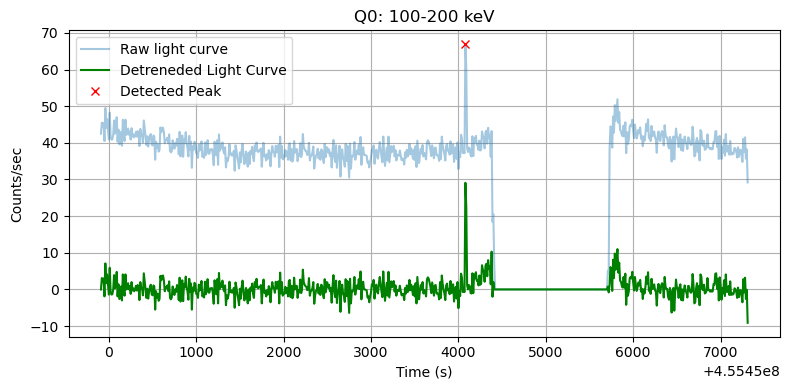

Peak at 455454085.50 sec, value = 83.00 cps


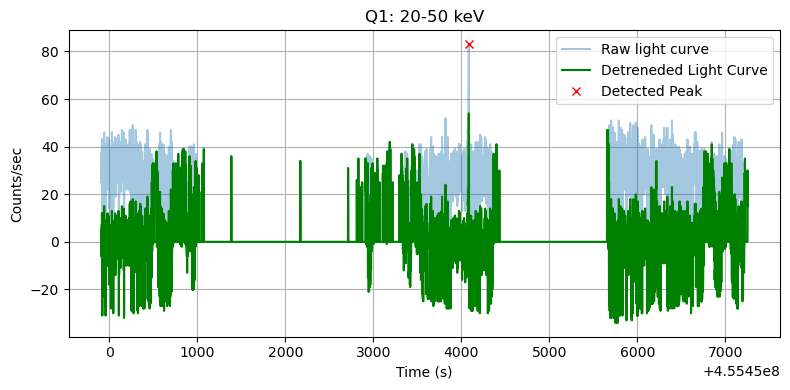

Peak at 455454083.50 sec, value = 116.00 cps
Peak at 455454085.50 sec, value = 166.00 cps


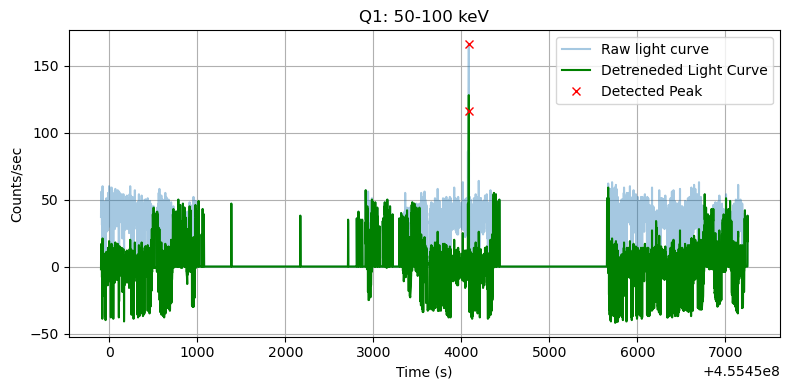

Peak at 455454083.53 sec, value = 153.00 cps
Peak at 455454085.53 sec, value = 178.00 cps
Peak at 455454087.53 sec, value = 120.00 cps


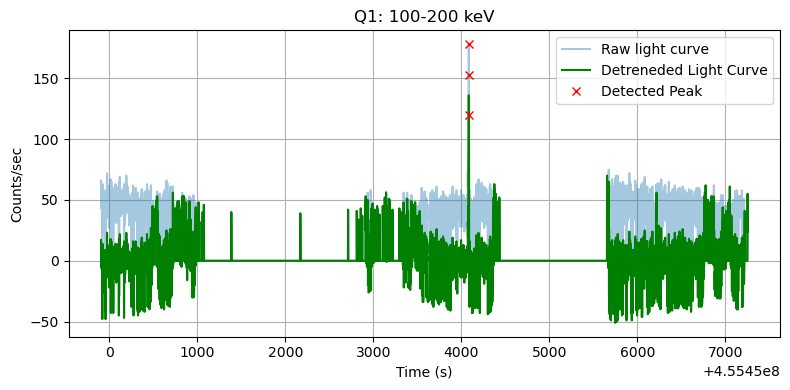

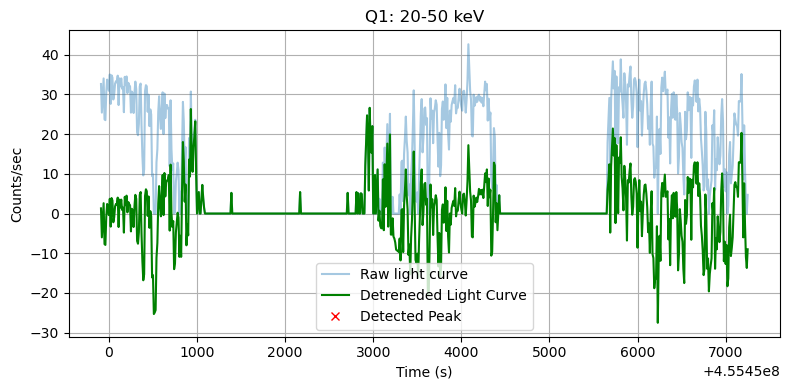

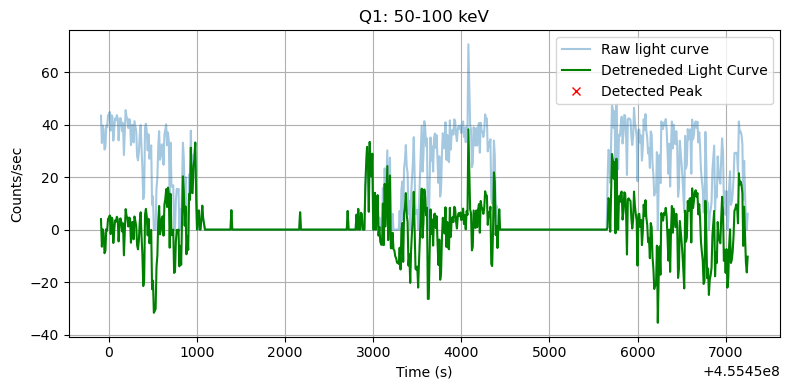

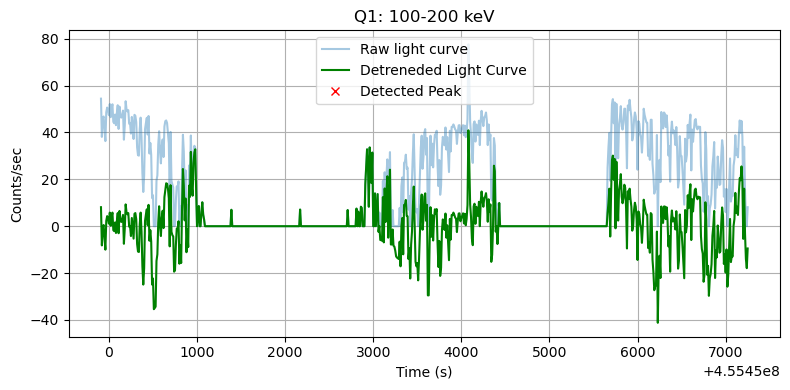

Peak at 455454085.55 sec, value = 71.00 cps
Peak at 455454449.55 sec, value = 46.00 cps
Peak at 455454451.55 sec, value = 46.00 cps
Peak at 455454453.55 sec, value = 48.00 cps
Peak at 455454458.55 sec, value = 40.00 cps
Peak at 455455646.55 sec, value = 43.00 cps


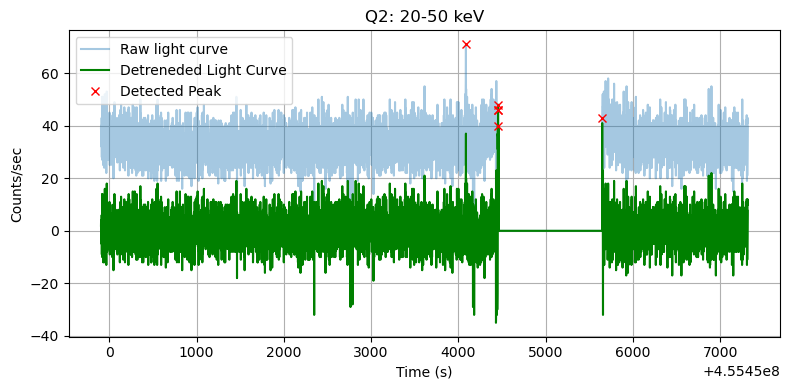

Peak at 455454085.52 sec, value = 79.00 cps
Peak at 455454449.52 sec, value = 50.00 cps
Peak at 455454451.52 sec, value = 52.00 cps
Peak at 455454453.52 sec, value = 40.00 cps
Peak at 455454458.52 sec, value = 58.00 cps
Peak at 455455647.52 sec, value = 54.00 cps


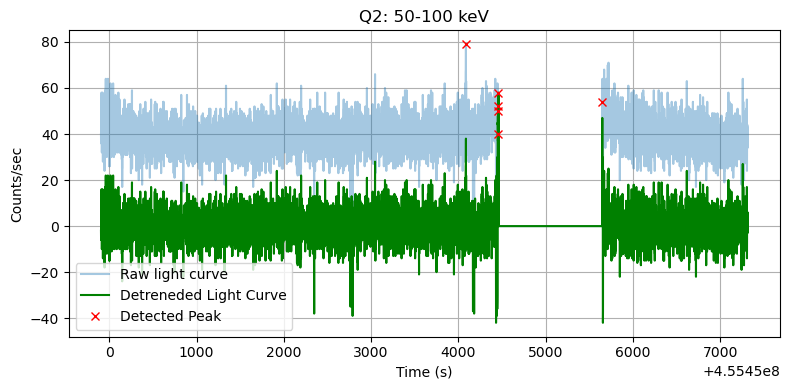

Peak at 455454083.50 sec, value = 89.00 cps
Peak at 455454085.50 sec, value = 102.00 cps
Peak at 455454087.50 sec, value = 92.00 cps
Peak at 455454450.50 sec, value = 54.00 cps
Peak at 455454453.50 sec, value = 57.00 cps
Peak at 455454458.50 sec, value = 51.00 cps
Peak at 455455646.50 sec, value = 57.00 cps


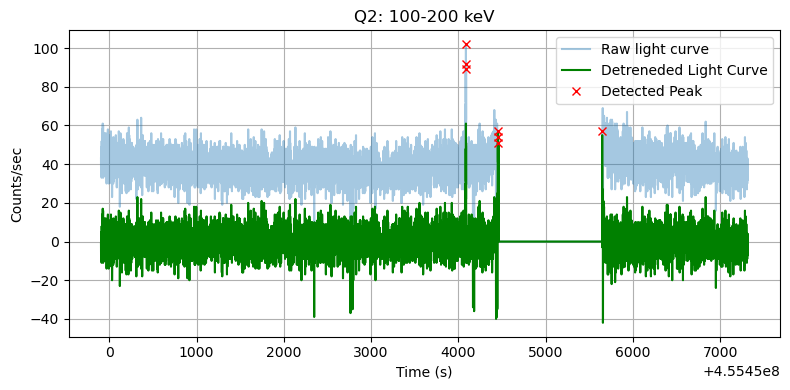

Peak at 455454450.05 sec, value = 36.50 cps
Peak at 455455670.05 sec, value = 44.30 cps
Peak at 455455690.05 sec, value = 44.00 cps


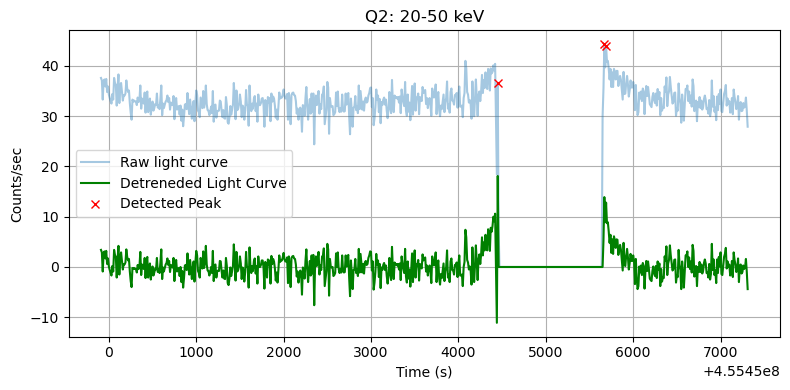

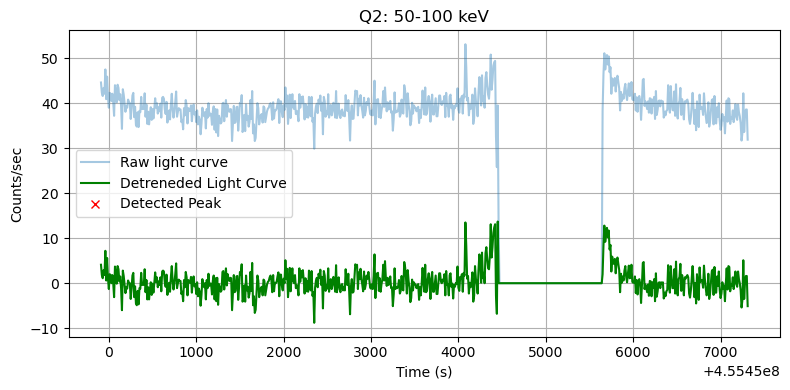

Peak at 455454080.00 sec, value = 57.60 cps
Peak at 455454450.00 sec, value = 42.00 cps


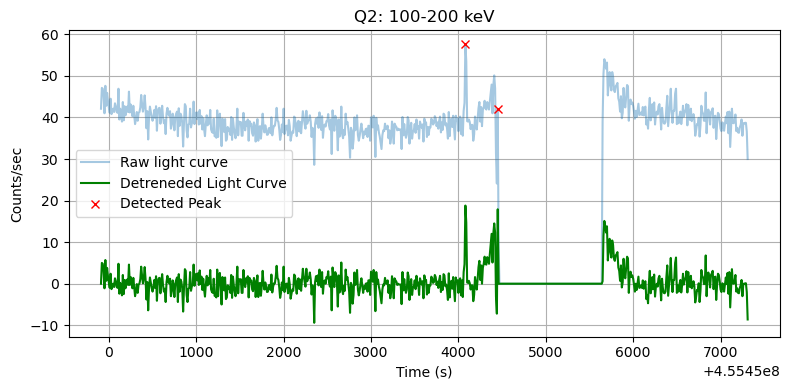

Peak at 455454444.56 sec, value = 44.00 cps
Peak at 455454453.56 sec, value = 49.00 cps
Peak at 455455650.56 sec, value = 37.00 cps
Peak at 455455652.56 sec, value = 41.00 cps


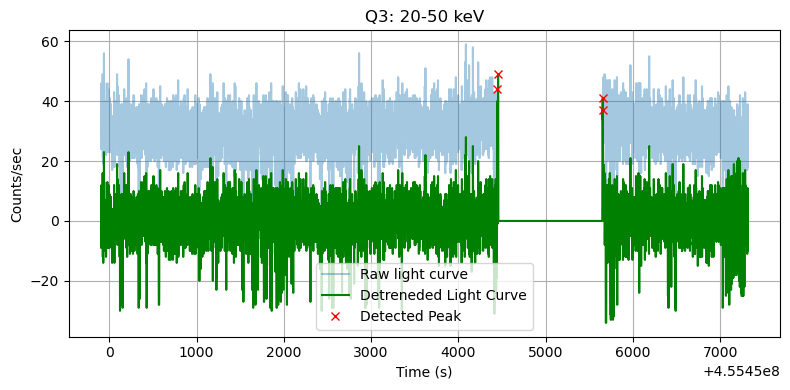

Peak at 455454085.52 sec, value = 90.00 cps
Peak at 455454445.52 sec, value = 48.00 cps
Peak at 455454453.52 sec, value = 52.00 cps
Peak at 455455649.52 sec, value = 48.00 cps
Peak at 455455651.52 sec, value = 54.00 cps


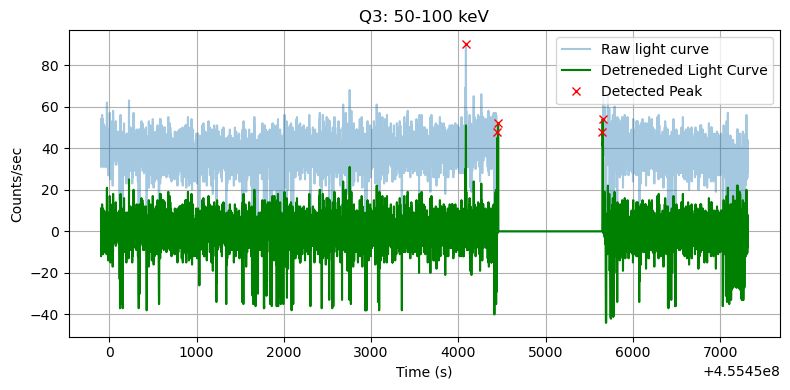

Peak at 455454085.56 sec, value = 83.00 cps
Peak at 455454444.56 sec, value = 47.00 cps
Peak at 455454453.56 sec, value = 52.00 cps
Peak at 455455651.56 sec, value = 65.00 cps
Peak at 455455655.56 sec, value = 70.00 cps


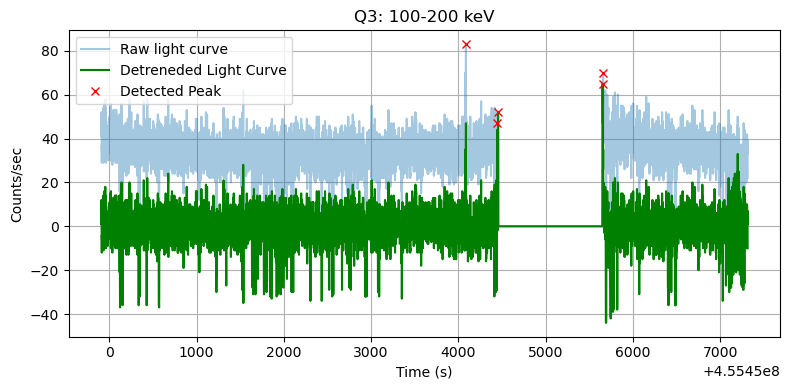

Peak at 455455660.06 sec, value = 39.00 cps


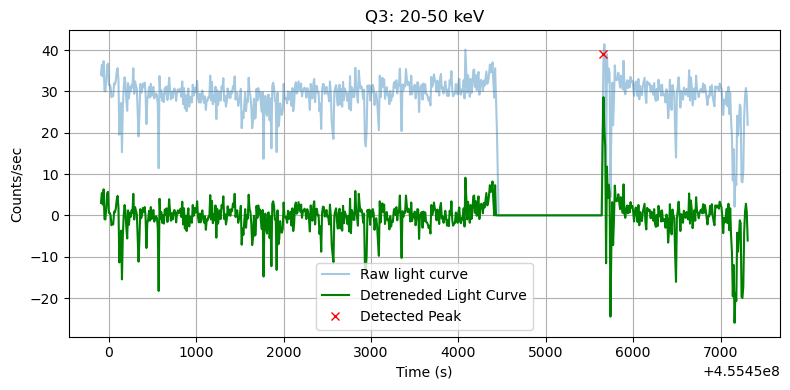

Peak at 455455660.02 sec, value = 50.10 cps


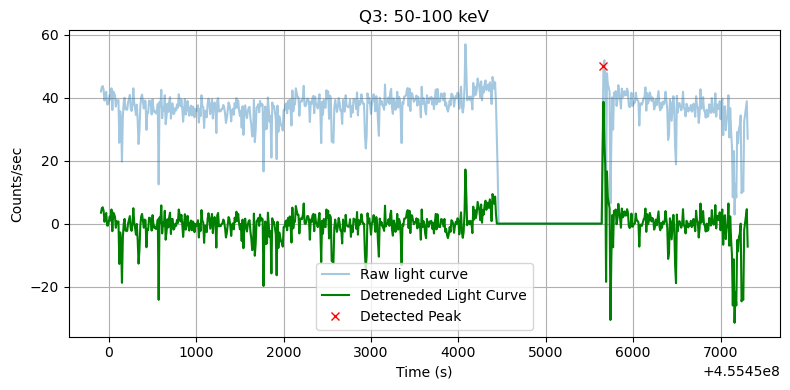

Peak at 455455660.06 sec, value = 51.90 cps


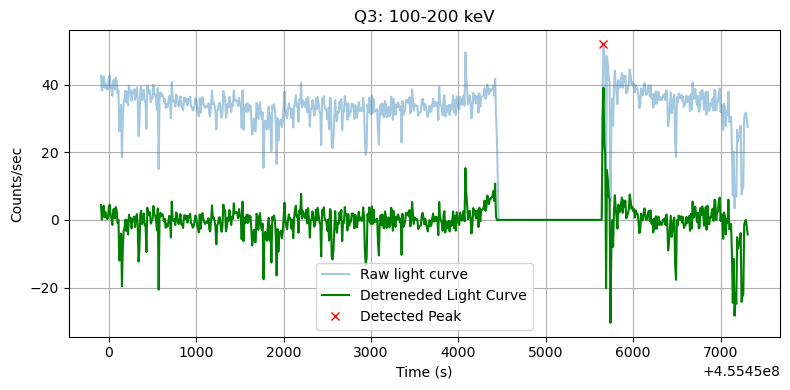

In [26]:
from scipy.signal import find_peaks, savgol_filter
lc_terms = [(x0,cps_q0,energy_q0,times_q0),
            (x1,cps_q1,energy_q1,times_q1),
            (x2,cps_q2,energy_q2,times_q2),
            (x3,cps_q3,energy_q3,times_q3),]
quadrant_labels = ['Q0','Q1','Q2','Q3']
n = 5 
energy_bands = [(20, 50), (50, 100), (100, 200)]
bin_widths = [1,10]
for q_idx, (x_raw, cps_raw, energy_raw, times_raw) in enumerate(lc_terms):
    quadrant_name = quadrant_labels[q_idx]
    for y in bin_widths:
         for (emin, emax) in energy_bands:
            mask = (energy_raw > emin) & (energy_raw < emax)
            times_filtered = times_raw[mask]
            x, cps = counts_per_sec(times_filtered, bin_width=y)

            filtered_signal = median_filter(cps, size=101)
            detrended_signal = cps - filtered_signal

            mean_fsignal = np.mean(detrended_signal)
            std_fsignal = np.std(detrended_signal)
            threshold = mean_fsignal + n * std_fsignal

            peaks, properties = find_peaks(detrended_signal, height=threshold)
            for i in peaks:
                print(f"Peak at {x[i]:.2f} sec, value = {cps[i]:.2f} cps")

            plt.figure(figsize=(8, 4))
            plt.plot(x,cps,alpha=0.4,label='Raw light curve')
            plt.plot(x, detrended_signal, label='Detreneded Light Curve',color='green')
            plt.plot(x[peaks],cps[peaks], 'rx', label='Detected Peak')
            plt.title(f"{quadrant_name}: {emin}-{emax} keV")
            plt.xlabel("Time (s)")
            plt.ylabel("Counts/sec")
            plt.legend()
            plt.grid()
            plt.tight_layout()
            plt.show()

### Using Nsigma simulation for VETO curves


 Q0 with bin width 1sec — Energy band 100-200 keV:
Strongest peak at 455454084.42 sec with value 969.00 cps


<Figure size 800x400 with 0 Axes>

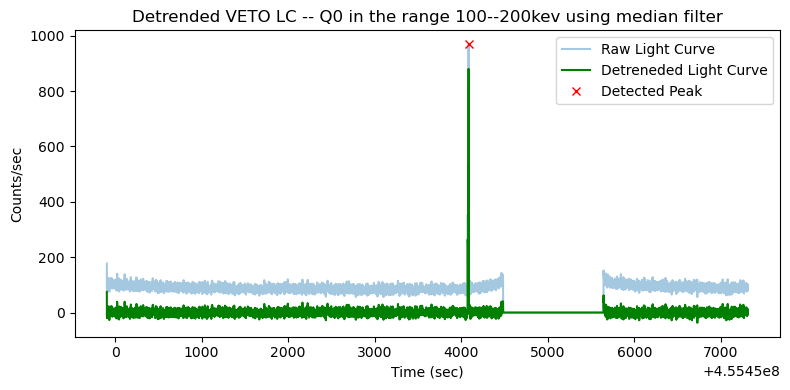


 Q1 with bin width 1sec — Energy band 100-200 keV:
Strongest peak at 455454084.42 sec with value 959.00 cps


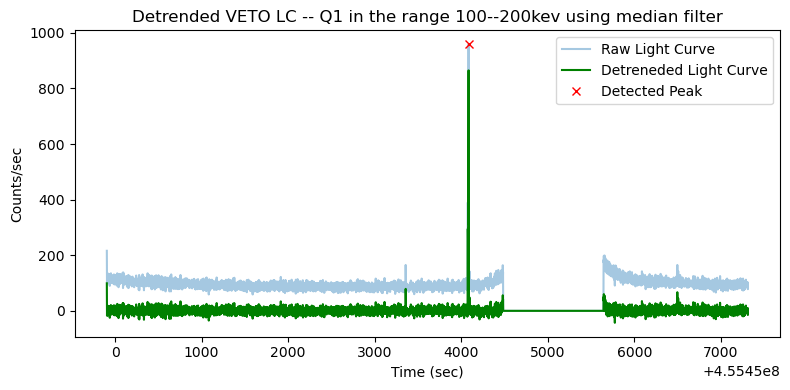


 Q2 with bin width 1sec — Energy band 100-200 keV:
Strongest peak at 455454084.42 sec with value 389.00 cps


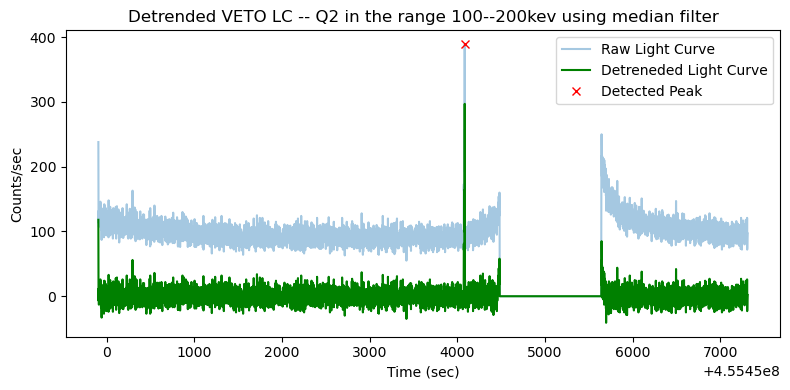


 Q3 with bin width 1sec — Energy band 100-200 keV:
Strongest peak at 455454084.42 sec with value 382.00 cps


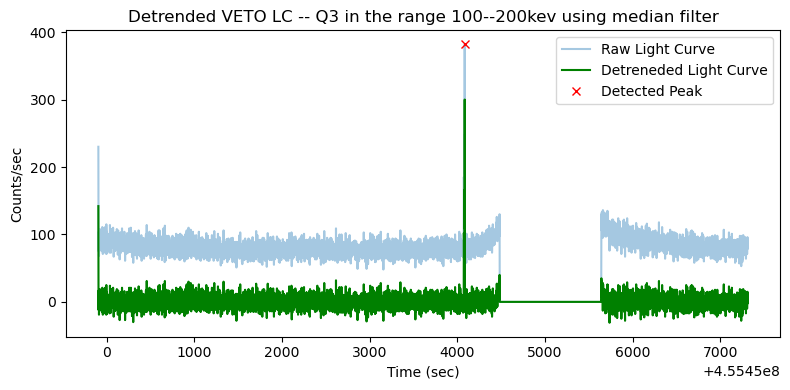


 Q0 with bin width 1sec — Energy band 200-500 keV:
Strongest peak at 455454084.42 sec with value 644.00 cps


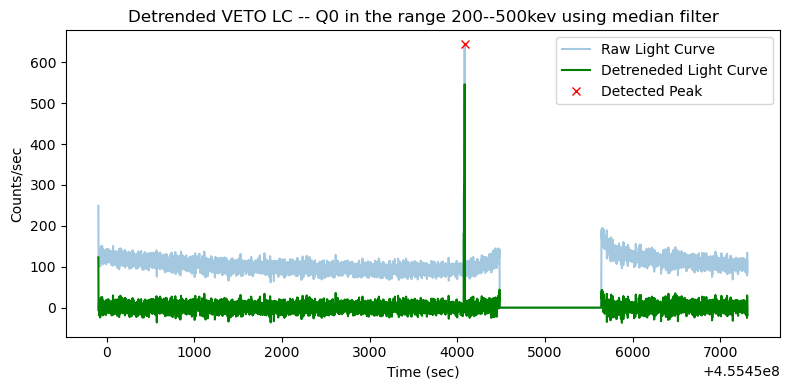


 Q1 with bin width 1sec — Energy band 200-500 keV:
Strongest peak at 455454084.42 sec with value 972.00 cps


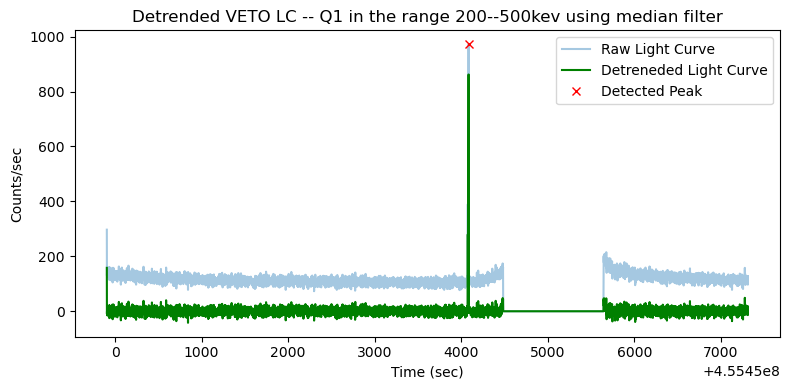


 Q2 with bin width 1sec — Energy band 200-500 keV:
Strongest peak at 455454084.42 sec with value 403.00 cps


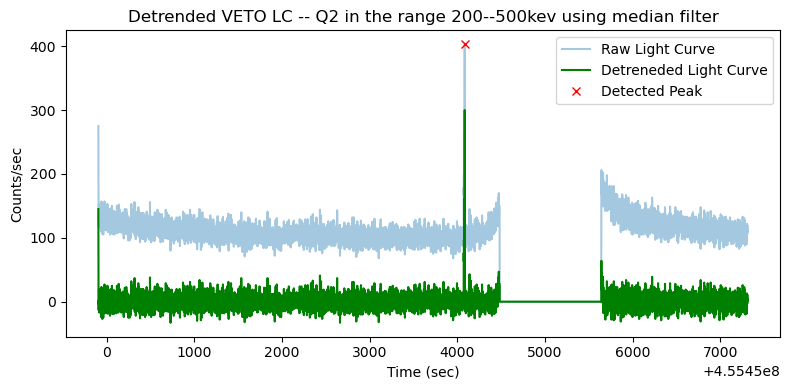


 Q3 with bin width 1sec — Energy band 200-500 keV:
Strongest peak at 455454084.42 sec with value 452.00 cps


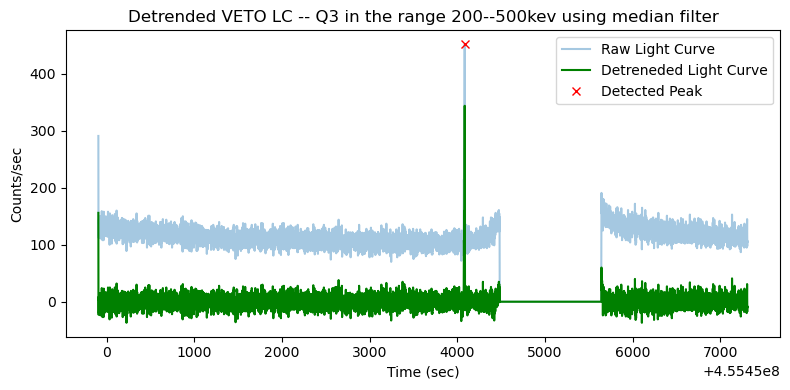


 Q0 with bin width 10sec — Energy band 100-200 keV:
Strongest peak at 455454078.92 sec with value 311.20 cps


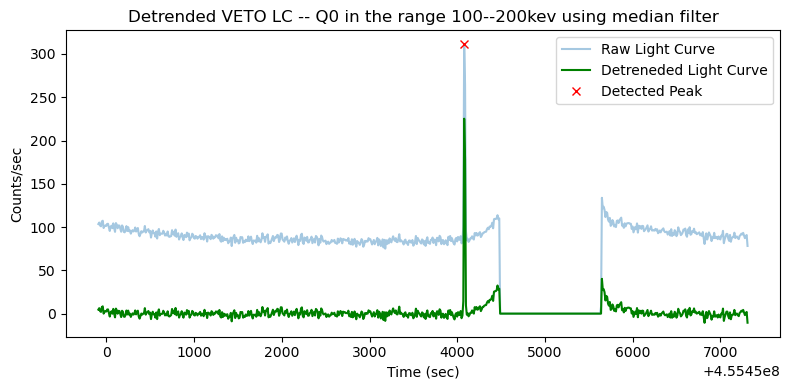


 Q1 with bin width 10sec — Energy band 100-200 keV:
Strongest peak at 455454078.92 sec with value 319.70 cps


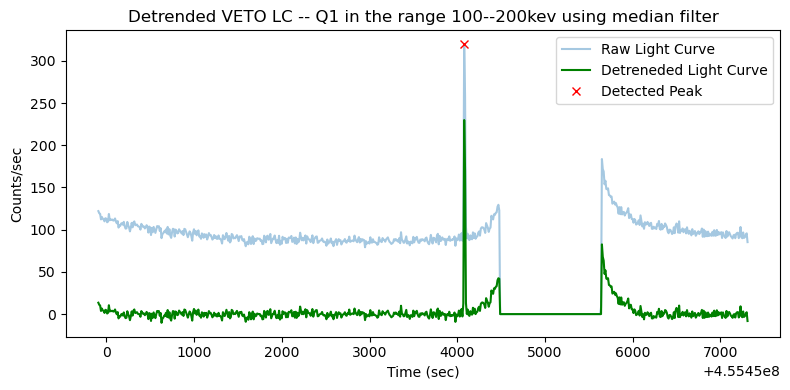


 Q2 with bin width 10sec — Energy band 100-200 keV:
Strongest peak at 455455647.92 sec with value 203.90 cps


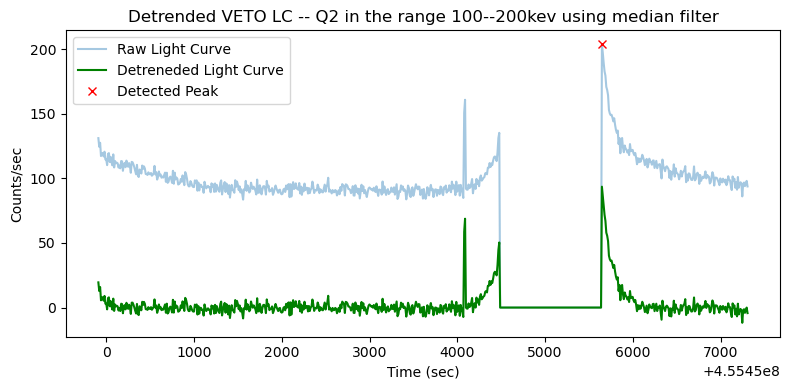


 Q3 with bin width 10sec — Energy band 100-200 keV:
Strongest peak at 455454077.92 sec with value 148.50 cps


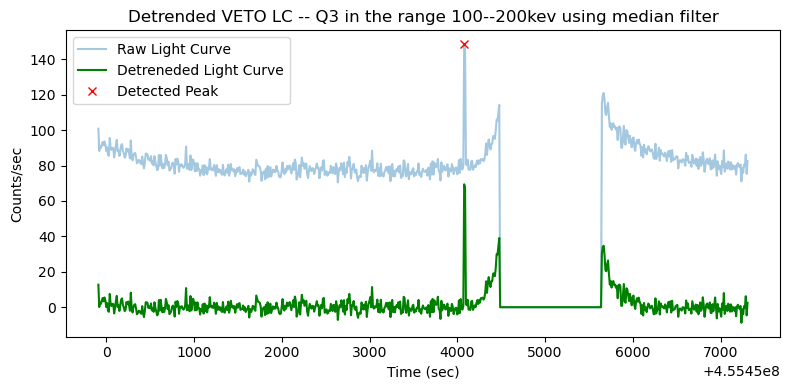


 Q0 with bin width 10sec — Energy band 200-500 keV:
Strongest peak at 455454078.92 sec with value 244.30 cps


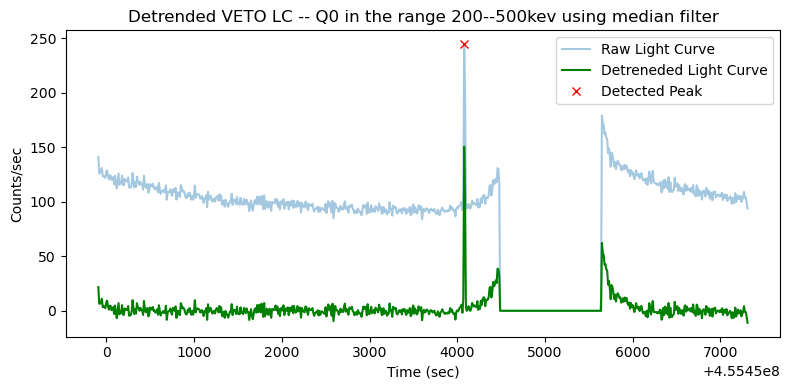


 Q1 with bin width 10sec — Energy band 200-500 keV:
Strongest peak at 455454078.92 sec with value 337.20 cps


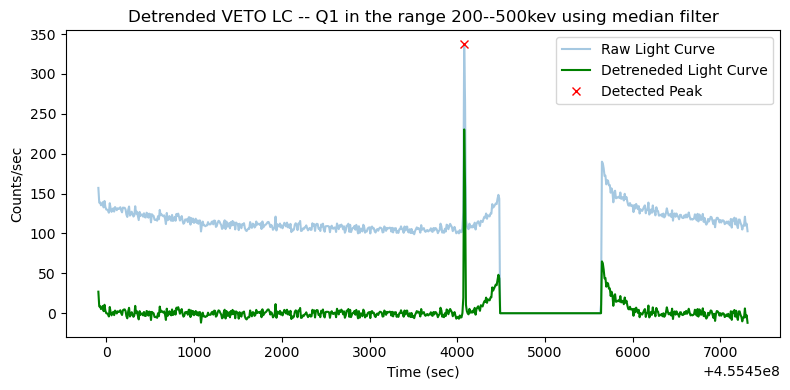


 Q2 with bin width 10sec — Energy band 200-500 keV:
Strongest peak at 455455657.92 sec with value 184.60 cps


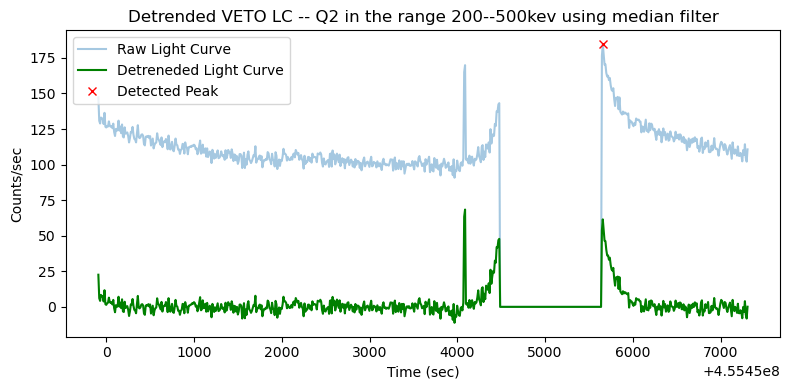


 Q3 with bin width 10sec — Energy band 200-500 keV:
Strongest peak at 455454087.92 sec with value 187.30 cps


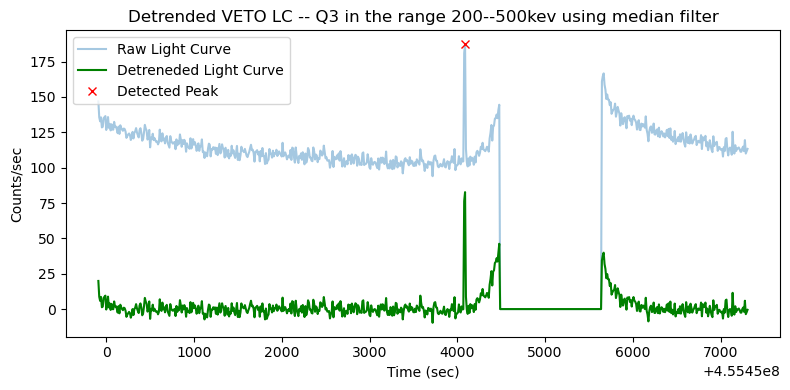

In [32]:
plt.figure(figsize=(8,4))
bin_widths=[1,10]
for y in bin_widths:
    for (emin, emax) in energyv:
        for q in range(4):
            idx = (quad == q)
            v_spec_q = vetospec[idx]
            times_q = vetotimes[idx]
            channels = np.arange(256)
            energies = channels * gain + offset
            mask = (energies >= emin) & (energies <= emax)

            counts_q = np.sum(v_spec_q[:, mask], axis=1)
            xv, cps_vals = cps_veto(times_q,y, counts_q)
            med9=median_filter(cps_vals,size=101)
            demed=cps_vals-med9
            mean_fsignal = np.mean(demed)
            std_fsignal = np.std(demed)
            threshold = mean_fsignal + n * std_fsignal

            peaks, properties = find_peaks(demed, height=threshold)
            if len(peaks) > 0:
                max_peak_idx = peaks[np.argmax(cps_vals[peaks])]
                max_peak_time = xv[max_peak_idx]
                max_peak_value = cps_vals[max_peak_idx]

                print(f"\n Q{q} with bin width {y}sec — Energy band {emin}-{emax} keV:")
                print(f"Strongest peak at {max_peak_time:.2f} sec with value {max_peak_value:.2f} cps")
            else:
                print(f"\n Q{q} with bin width {y}sec — Energy band {emin}-{emax} keV:")
                print("No peak found above threshold.")

            plt.figure(figsize=(8, 4))
            plt.plot(xv,cps_vals,alpha=0.4,label='Raw Light Curve')
            plt.plot(xv, demed, label='Detreneded Light Curve',color='green')
            plt.plot(max_peak_time, max_peak_value, 'rx', label='Detected Peak')
            plt.title(f"Detrended VETO LC -- Q{q} in the range {emin}--{emax}kev using median filter")
            plt.xlabel('Time (sec)')
            plt.ylabel('Counts/sec')
            plt.tight_layout()
            plt.legend()
            plt.show()

### Finding the SNR for all the plots above


SNR (on detrended curve) — Q0, Bin width 1s and 10s, Energy 20-50 keV:


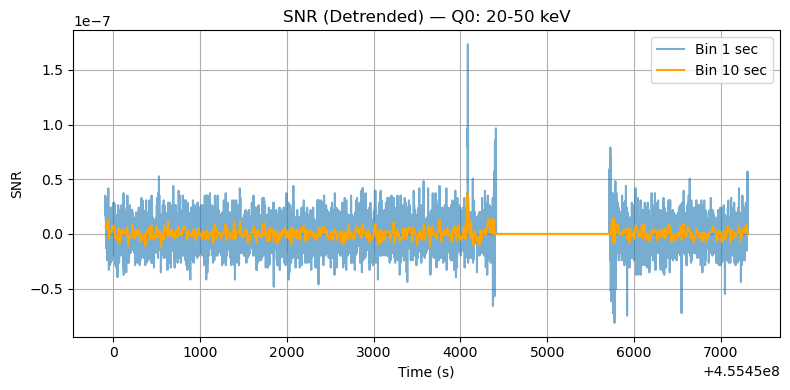


SNR (on detrended curve) — Q0, Bin width 1s and 10s, Energy 50-100 keV:


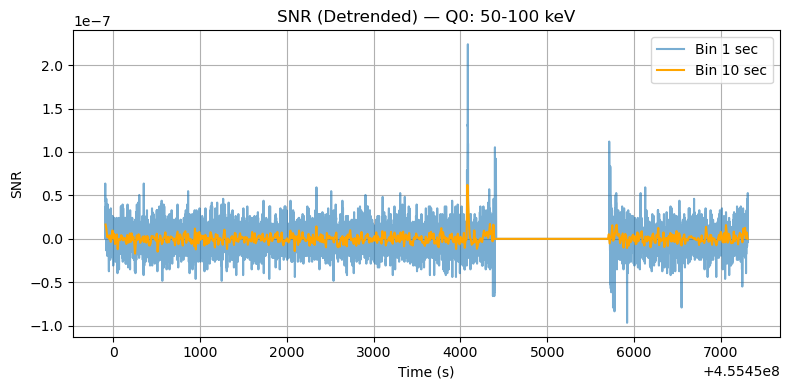


SNR (on detrended curve) — Q0, Bin width 1s and 10s, Energy 100-200 keV:


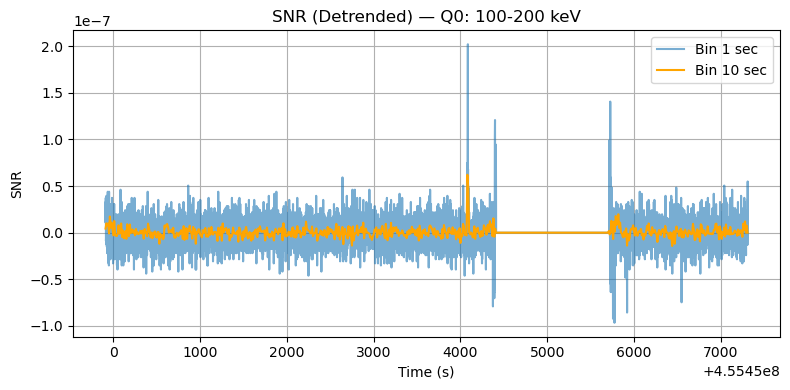


SNR (on detrended curve) — Q1, Bin width 1s and 10s, Energy 20-50 keV:


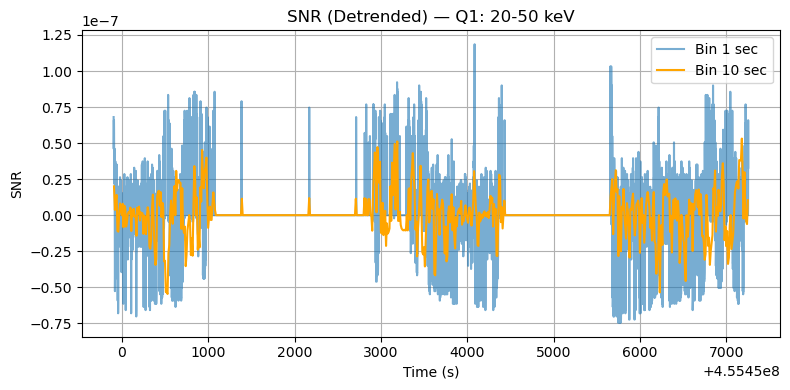


SNR (on detrended curve) — Q1, Bin width 1s and 10s, Energy 50-100 keV:


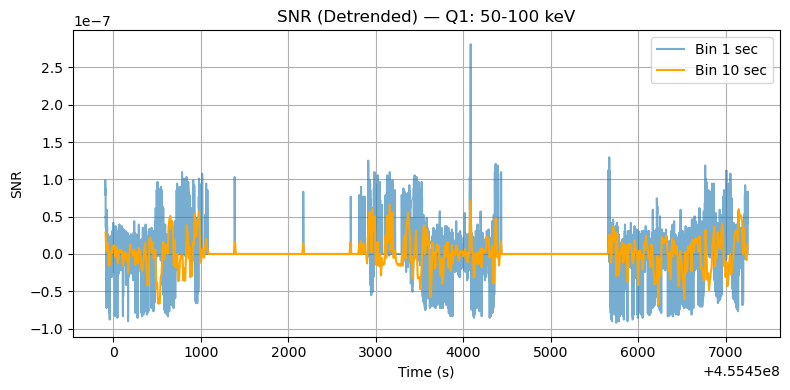


SNR (on detrended curve) — Q1, Bin width 1s and 10s, Energy 100-200 keV:


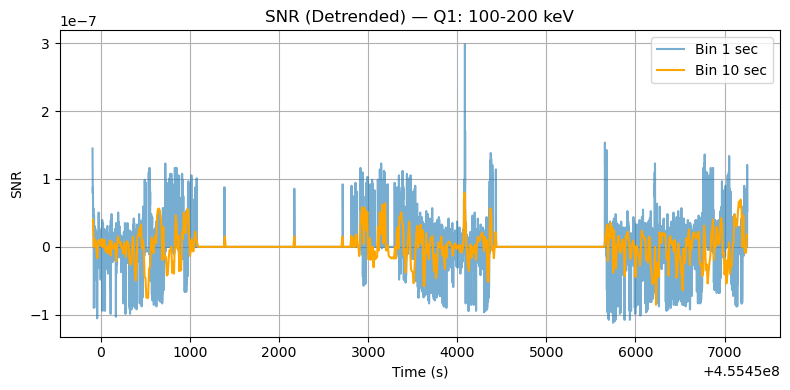


SNR (on detrended curve) — Q2, Bin width 1s and 10s, Energy 20-50 keV:


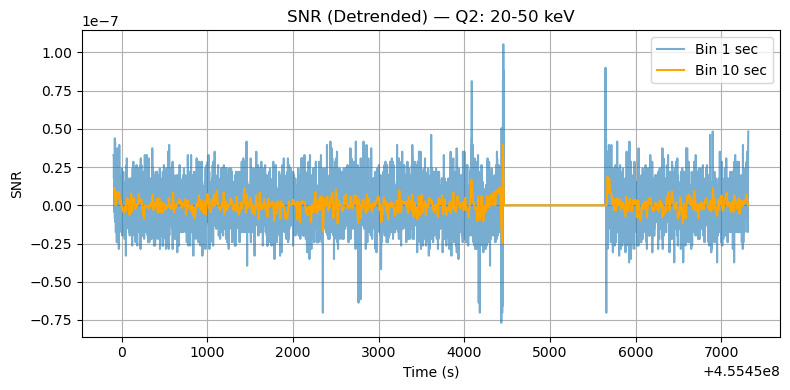


SNR (on detrended curve) — Q2, Bin width 1s and 10s, Energy 50-100 keV:


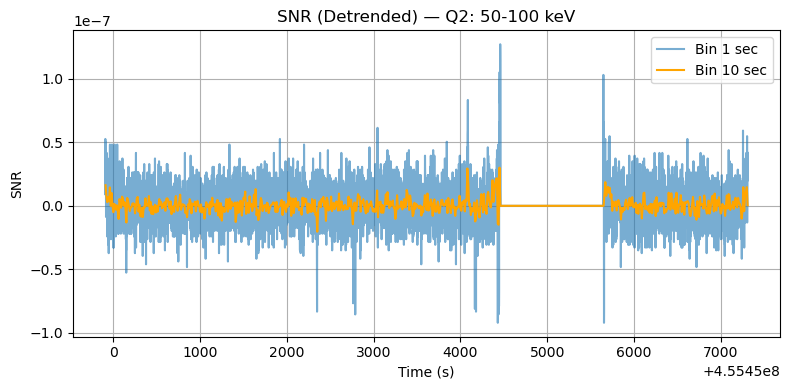


SNR (on detrended curve) — Q2, Bin width 1s and 10s, Energy 100-200 keV:


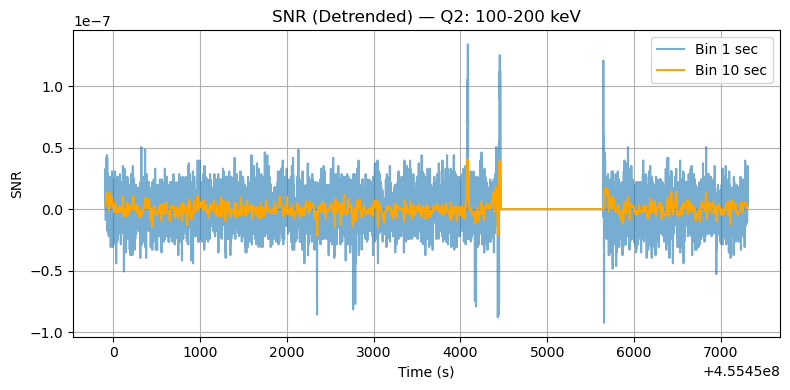


SNR (on detrended curve) — Q3, Bin width 1s and 10s, Energy 20-50 keV:


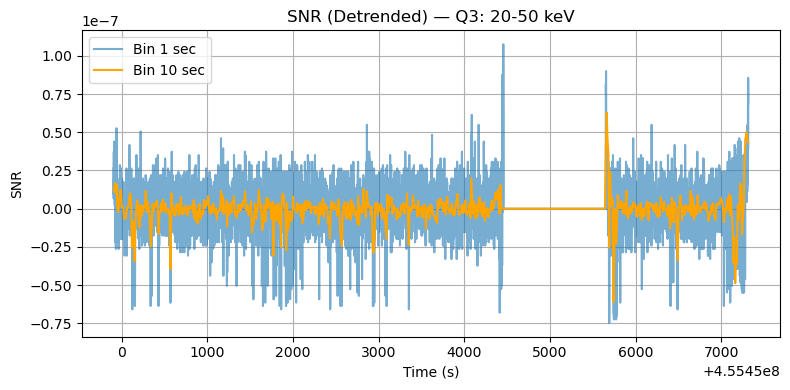


SNR (on detrended curve) — Q3, Bin width 1s and 10s, Energy 50-100 keV:


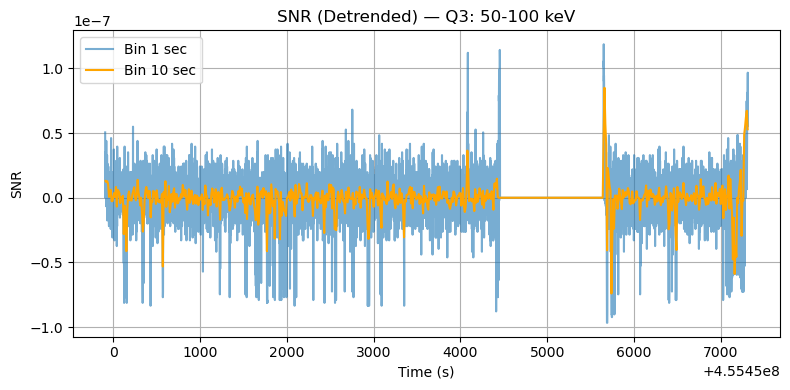


SNR (on detrended curve) — Q3, Bin width 1s and 10s, Energy 100-200 keV:


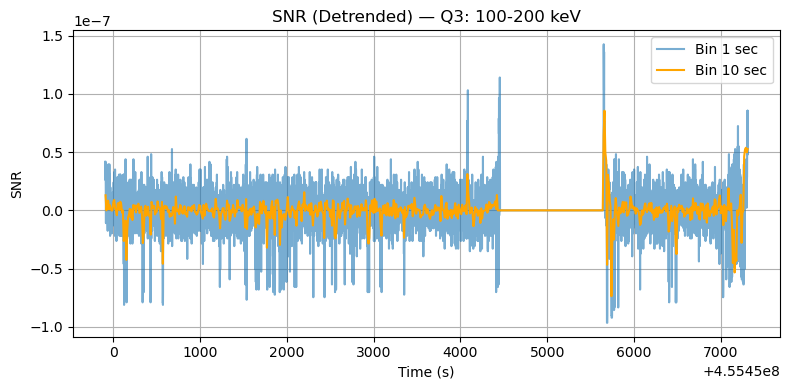

In [27]:
from scipy.signal import medfilt
import numpy as np
import matplotlib.pyplot as plt

lc_terms = [(energy_q0, times_q0),
            (energy_q1, times_q1),
            (energy_q2, times_q2),
            (energy_q3, times_q3)]
quadrant_labels = ['Q0', 'Q1', 'Q2', 'Q3']
energy_bands = [(20, 50), (50, 100), (100, 200)]


for q_idx, (energy_raw, times_raw) in enumerate(lc_terms):
    quadrant_name = quadrant_labels[q_idx]
    for (emin, emax) in energy_bands:
       
        mask = (energy_raw > emin) & (energy_raw < emax)
        times_filtered = times_raw[mask]

    
        x, cps = counts_per_sec(times_filtered, bin_width=1)
        bkg = (x >= 0) & (x <= 1000 + eps)

        cps_smooth = medfilt(cps, kernel_size=101)
        detrended = cps - cps_smooth
        noise = np.std(detrended[bkg])
        snr = detrended / (noise+eps)

       
        xt, cpst = counts_per_sec(times_filtered, bin_width=10)
        bkgt = (xt >= 0) & (xt <= 1000 + eps)

        cpst_smooth = medfilt(cpst, kernel_size=31)
        detrended_t = cpst - cpst_smooth
        noiset = np.std(detrended_t[bkgt])
        snrt = detrended_t / (noiset+eps)

       
        print(f"\nSNR (on detrended curve) — {quadrant_name}, Bin width 1s and 10s, Energy {emin}-{emax} keV:")
        plt.figure(figsize=(8, 4))
        plt.plot(x, snr, label='Bin 1 sec', alpha=0.6)
        plt.plot(xt, snrt, label='Bin 10 sec', color='orange')
        plt.title(f"SNR (Detrended) — {quadrant_name}: {emin}-{emax} keV")
        plt.xlabel("Time (s)")
        plt.ylabel("SNR")
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()


In [28]:
print(len(times_q))
print(len(counts_q))

6251
6251


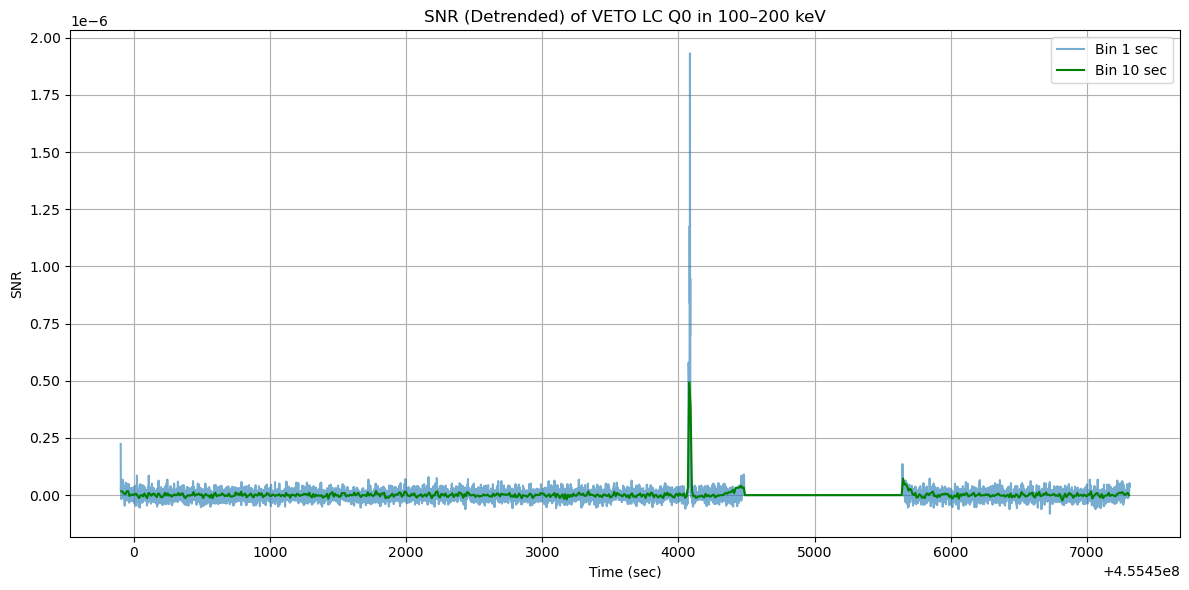

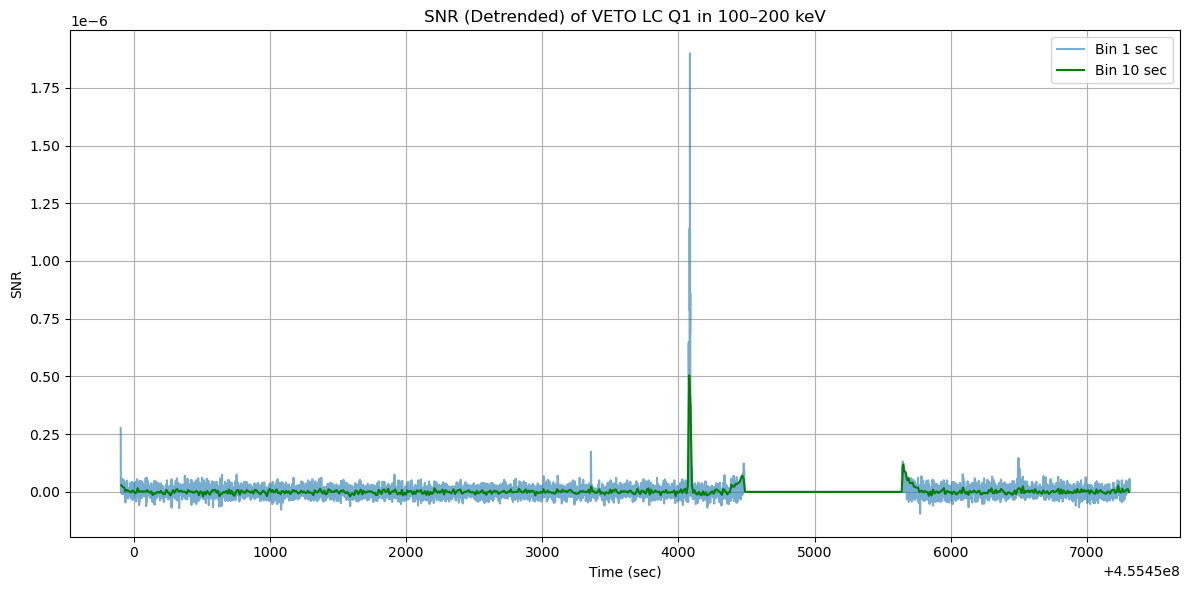

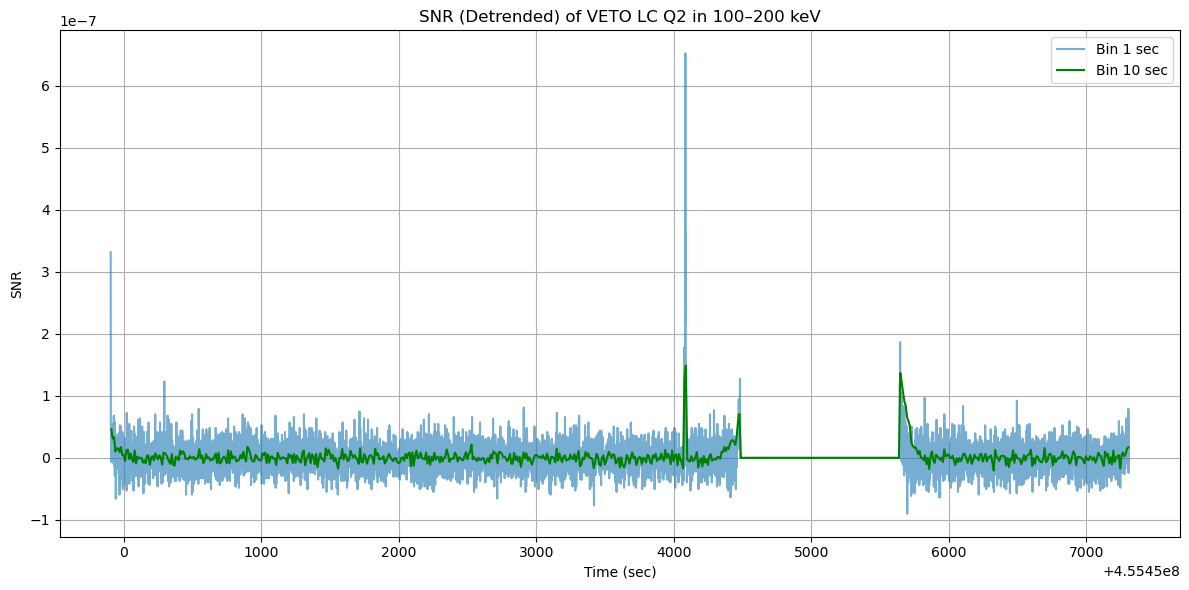

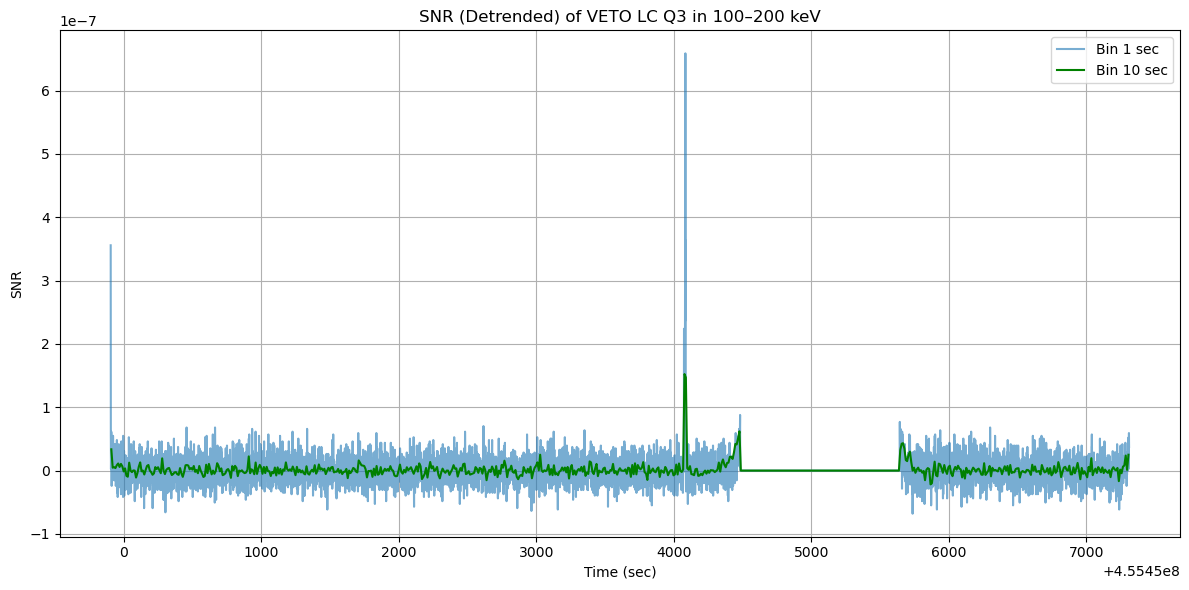

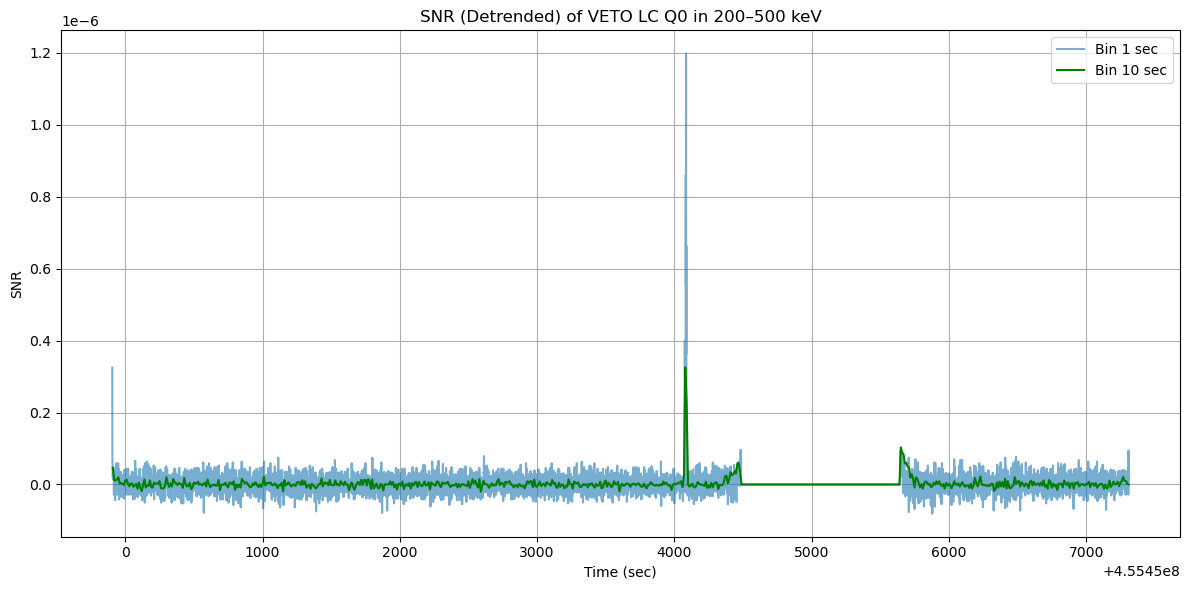

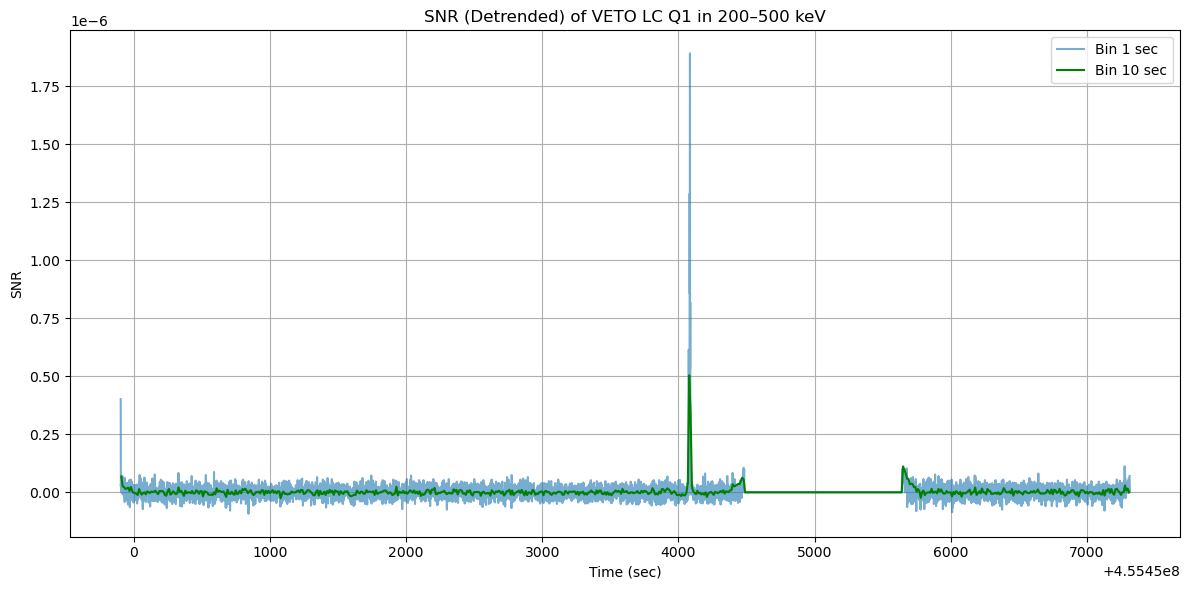

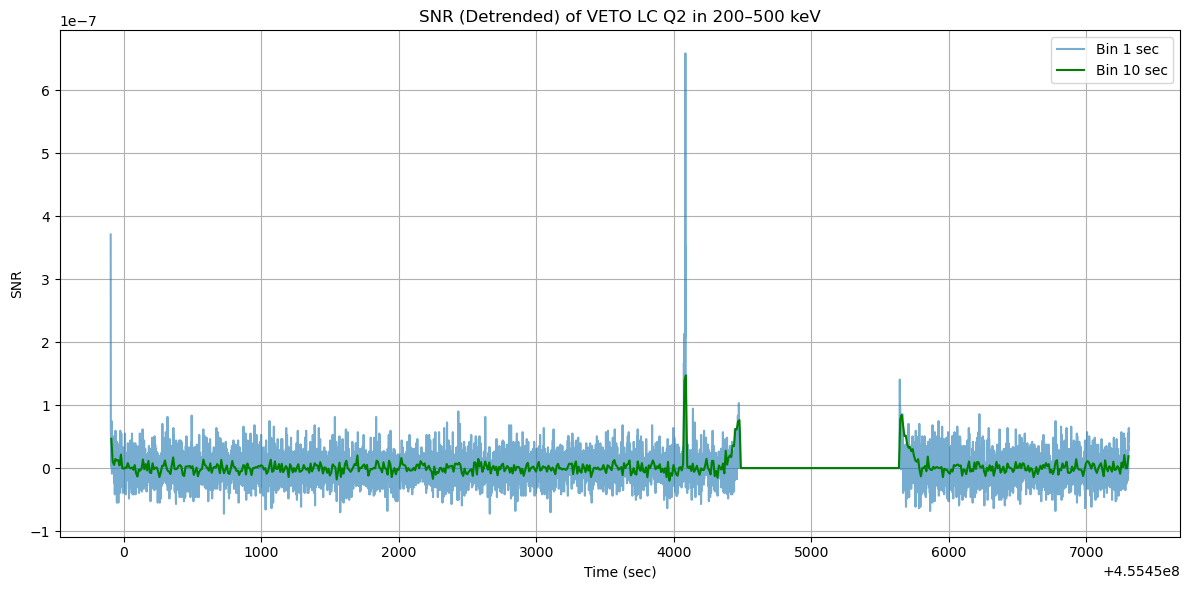

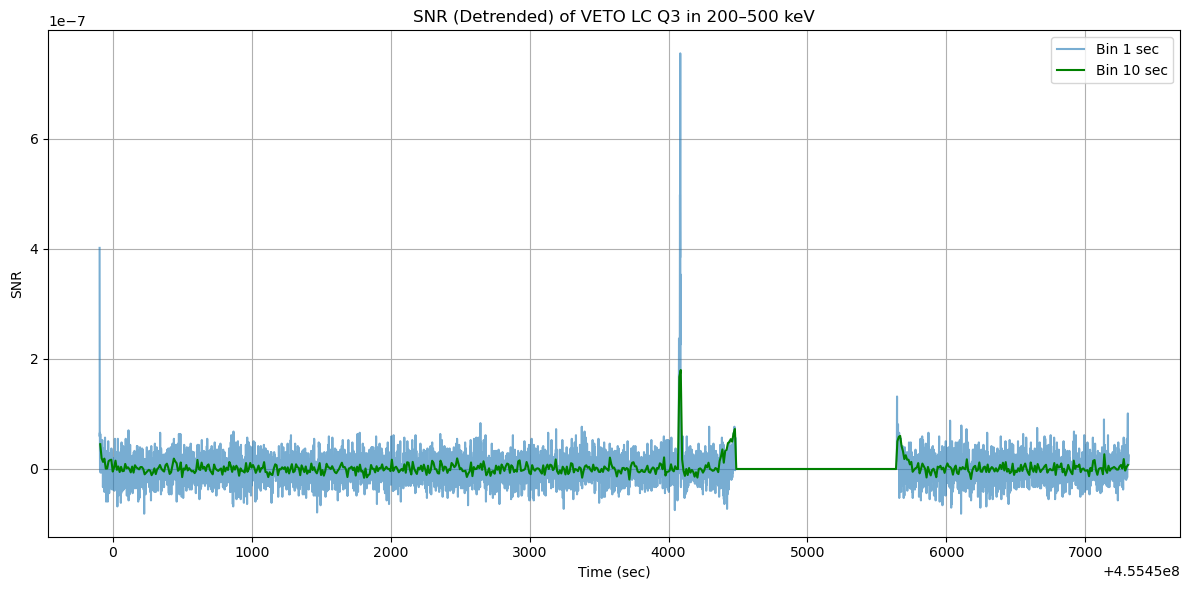

In [29]:
from scipy.signal import medfilt
import numpy as np
import matplotlib.pyplot as plt

bin_width = 1
kernel_1s = 101  # You can adjust this depending on data duration
kernel_10s = 31


for (emin, emax) in energyv:
    for q in range(4):
        idx = (quad == q)
        v_spec_q = vetospec[idx]
        times_q = vetotimes[idx]
        channels = np.arange(256)
        energies = channels * gain + offset
        mask = (energies >= emin) & (energies <= emax)

        # Integrate spectrum over energy band
        counts_q = np.sum(v_spec_q[:, mask], axis=1)

        # Bin width = 1 sec
        xv, cps_vals = cps_veto(times_q, 1, counts_q)
        cps_smooth = medfilt(cps_vals, kernel_size=kernel_1s)
        detrended = cps_vals - cps_smooth

        bkg_mask = (xv >= 0) & (xv <= 4000 + eps)
        noise_v = np.std(detrended[bkg_mask])
        signal_v = detrended / (noise_v + eps)

        # Bin width = 10 sec
        xv1, cps_vals1 = cps_veto(times_q, 10, counts_q)
        cps_smooth1 = medfilt(cps_vals1, kernel_size=kernel_10s)
        detrended1 = cps_vals1 - cps_smooth1

        bkg_mask1 = (xv1 >= 0) & (xv1 <= 4000 + eps)
        noise_v1 = np.std(detrended1[bkg_mask1])
        signal_v1 = detrended1 / (noise_v1 + eps)

        # Plot
        plt.figure(figsize=(12, 6))
        plt.plot(xv, signal_v, label='Bin 1 sec', alpha=0.6)
        plt.plot(xv1, signal_v1, label='Bin 10 sec', color='green')
        plt.title(f'SNR (Detrended) of VETO LC Q{q} in {emin}–{emax} keV')
        plt.xlabel('Time (sec)')
        plt.ylabel('SNR')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
